In [4]:
# default_exp optim_w_augment_3
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Experiment 3 Rerun 4: Optimising With Augmentation Using the Empirically Matched Model

> Optimisation the whole alphabet using the empirically matched OCR model from notebook 14 and with augmented renderings for `OCRLoss`.

In [5]:
#export
from aifont.core import *
from aifont.fontlearner import *
from aifont.fontsampler import *
from aifont.ocrlearner import *
from collections import OrderedDict
from enum import Enum, auto
from fastai.data.all import *
from fastai.vision.all import *
import gc
from nbdev.showdoc import *
from pandas import DataFrame
from PIL.ImageOps import invert
import pydiffvg
import torch
from typing import Callable, List, Protocol, Tuple, Union

## Common variables

In [6]:
DUMP_FOLDER = Path("results/test_nb12_augmented")
EMPIRICAL_MODEL_FN = "cornet_v4_matching_vdh_conf_matrix.pth"
EMPIRICAL_MODEL_2_FN = "cornet_v4_matching_decoder_vdh_conf_matrix.pth"
EMPIRICAL_MODEL_3_FN = "cornet_v4_matching_decoder_vdh_conf_matrix_no_trapad_2.pth"
OCR_FNS = (EMPIRICAL_MODEL_FN, "cornet_all_matching_vdh_conf_matrix.pth")
BEST_PARAMS_PATH = DUMP_FOLDER/"best_font_params_for_cornet_v4_matching_vdh_conf_matrix.pkl"
BEST_PARAMS_2_PATH = DUMP_FOLDER/"best_font_params_for_cornet_v4_matching_decoder_vdh_conf_matrix.pkl"
BEST_PARAMS_3_PATH = DUMP_FOLDER/"best_font_params_for_cornet_v4_matching_decoder_vdh_conf_matrix_no_trapad.pkl"
BEST_PARAMS_3_THIN_STROKE_PATH = DUMP_FOLDER/"best_font_params_for_cornet_v4_matching_decoder_vdh_conf_matrix_no_trapad_thin_stroke.pkl"
# Fully optimised with frozen thin stroke
BEST_PARAMS_4_THIN_STROKE_PATH = DUMP_FOLDER/"best_font_params_for_cornet_v4_matching_decoder_vdh_conf_matrix_no_trapad_thin_stroke_2.pkl"
ALT_PARAMS_PATH = DUMP_FOLDER/"alt_font_params_for_cornet_v4_matching_decoder_vdh_conf_matrix.pkl"
ARIAL_PARAMS_PATH = "final_experiment_results/param_dict_for_match_font_arial.pkl"
ARIAL_SIZE_95_PARAMS_PATH = "final_experiment_results/param_dict_for_match_font_arial_size_95.pkl"


## Font Learner Factory

For this notebook only.

In [7]:
def get_learner(
    ocr_fn = EMPIRICAL_MODEL_FN,
    ocr_arch = cornet_for_ocr,
    n_out = 26,
    seed = None,
    tfms_p = 1., 
    bs = None,
    translate_and_pad=.2, # See Nb 14 for these values
    blur_size=17, # See Nb 14
    blur_sigma=(4.41 - .2, 4.41 + .2), # See Nb 14 + added a bit of random variation,
    init_range=2.,
    **kwargs
) -> VectorLearner:
    gc.collect()
    ocr_model = load_ocr_model(file=ocr_fn, arch=ocr_arch, n_out=n_out)
    ocr_tfms = [
        Pad((48 - 28) // 2, fill=1.),
        ToRGB(),
        # DebugTfm("After Pad"),
        get_imagenet_norm(),
        # TranslateAndPad(p=tfms_p, max_x=translate_and_pad, max_y=translate_and_pad),
        GaussianBlur(p=tfms_p, sigma=blur_sigma, kernel_size=(blur_size,)*2)
        ]
    # ocr_tfms += [Noise(p=tfms_p, f=(0., noise))]
    learner = create_font_learner(ocr_tfms=ocr_tfms if len(ocr_tfms) else None,
                                  letters=None,
                                  ocr_model=ocr_model,
                                  n_colors_out=1,
                                  lr=1e-1, 
                                  init_range=init_range,
                                  seed=seed,
                                  bs=bs,
                                  **kwargs
                                  )
    assert len(learner.loss_func.ocr_loss.tfms) == len(ocr_tfms)
    return learner

## Optimisation Utilities

Copied from `05_full_aphabet_optimisation.ipynb`. 

In [8]:
class ParamRecorderCB(Callback):
    best: dict = None
    best_on = None
    last_best_loss = None
    results: list[dict] = []
    def __init__(self, 
        max_epochs_after_best: int = None, 
        *args, **kwargs
        ):
        super(ParamRecorderCB, self).__init__(*args, **kwargs)
        store_attr("max_epochs_after_best")
    def before_fit(self):
        self.best_on = 0
        if self.best is None: self.last_best_loss = self.get_current_loss()
    def after_loss(self):
        if not self.training: return
        l  = self.loss.item()
        lr = self.opt.hypers[-1]["lr"]
        p  = self.get_param_dict()
        if not self.best or l < self.best["loss"]:
            self.best = dict(loss=l, lr=l, params=p)
            self.best_on = self.epoch
        elif self.max_epochs_after_best is not None and \
             self.epoch - self.best_on > self.max_epochs_after_best:
            raise CancelFitException()
    def after_fit(self):
        impr = self.last_best_loss - self.best["loss"]
        self.last_best_loss = self.best["loss"]
        impr_fr = impr / (self.last_best_loss + EPS)
        self.results.append(dict(impr=impr, 
                                 impr_fr=impr_fr,
                                 stopped_at=self.epoch,
                                 n_epochs=self.n_epoch,
                                 **self.best))
        print(f"Improvement {impr:.4f} ({impr_fr:.2%})")
    def reset_to_best(self):
        """Reset to the best saved parameters."""
        assert self.best
        self.load_param_dict(self.best["params"])

def plot_variation_results(
    variations: list[dict],
    figsize = (6, 6),
    lim: float = None
    ) -> None:
    """Plot the results from `fancy_fit_2_variations`."""
    df = DataFrame(variations)
    if lim is None: lim = math.ceil(max(df.init_loss)) 
    init_med, final_med = np.median(df.init_loss), np.median(df.final_loss)
    impr_med = np.median((df.init_loss - df.final_loss) / df.init_loss)
    min_loss = df.final_loss.min()
    fig = plt.figure(figsize=figsize)
    ax  = plt.gca()
    ax.set_xlim(0, lim), ax.set_ylim(0, lim)
    ax.scatter(df.init_loss, df.final_loss)
    ax.scatter(init_med, final_med)
    plt.suptitle(f"Initial losses vs final losses\n(median in orange, median improvement {impr_med:.2%},\nmin loss {min_loss:.4f})")
    plt.xlabel(f"Initial loss"), plt.ylabel(f"Final loss")

def show_variation_renders(
    variations: Union[list[dict], DataFrame],
    n = 12,
    n_cols = 4,
    fig_width = 14,
    incl_tfms = False,
    learner: VectorLearner = None,
    rerender = False,
    title_sfx = "",
    loss_col = "final_loss",
    param_col = "final_params",
    ) -> plt.Figure:
    """Show the rendered images together with losses, possibly paired with loss-function-transformed images."""
    assert all([o in variations[0] for o in (loss_col, param_col)])
    if incl_tfms and "img_with_tfms" not in variations[0]:
        assert learner is not None, "You must supply a learner if incl_tfms is True and variations don't contain img_with_tfms."
    assert not rerender or learner, "You must supply a learner if rerender is True"
    if type(variations) is list: variations = DataFrame(variations)
    variations = variations.sort_values(by=loss_col).reset_index()
    n_imgs = n if n is not None and len(variations) > n else len(variations)
    if incl_tfms: n_imgs *= 2
    n_rows = math.ceil(n_imgs / n_cols)
    if rerender: 
        img_ratio = learner.canvas_height / learner.canvas_width
    else: 
        _img = variations.iloc[0].img
        img_ratio = _img.height / _img.width
    fig_height = (fig_width / n_cols * img_ratio + .5) * n_rows
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(fig_width, fig_height))
    axs = axs.flatten()
    def _do_rend(v, apply_tfms=False):
        return learner.load_param_dict(v[param_col]).render_letters(apply_tfms=apply_tfms)
    for i, ax in enumerate(axs):
        if i >= n_imgs: break
        is_tfmd = incl_tfms and i % 2 == 1
        v = variations.iloc[i//2 if incl_tfms else i]
        if is_tfmd: img = v.img_with_tfms if not rerender and "img_with_tfms" in v else _do_rend(v, True)
        else:       img = v.img if not rerender else _do_rend(v)
        ax.imshow(img)
        ax.set_title("With loss tfms" if is_tfmd else f"Loss {v[loss_col]:.4f}")
    title = f"Rendered fonts and losses: {title_sfx}"
    if incl_tfms: title += "\nwith examples of loss-function-transformed images\n(Note that true transforms may be randomised)"
    fig.suptitle(title)
    plt.show()
    return fig

def avg_loss(
    learner,
    n = 20,
    return_list = False
    ) -> float:
    """Calc avg loss over `n` iterations."""
    losses = []
    for i in range(n): losses.append(learner.get_current_loss())
    return losses if return_list else sum(losses) / n

def print_losses(
    losses: Union[list, np.array], 
    msg = None
    ) -> dict:
    """Print basic stats of losses."""
    if msg is not None: msg += ": "
    losses = np.array(losses)
    l_mean = losses.mean()
    l_std = losses.std()
    l_spread = losses.max() - losses.min()
    print(f"{msg}Mean: {l_mean:.4f} • SD: {l_std:.4f} ({l_std / l_mean:.1%}) • Spread {l_spread:.4f} ({l_spread / l_mean:.1%})")
    return(dict(mean=l_mean, std=l_std, spread=l_spread))

def get_individual_losses(
    learner,
    iters = 20
    ) -> np.array:
    """Get losses for individual letters. Mean over `iters`."""
    loss = OCRLoss(ocr_model=load_ocr_model(arch=kaggle_cnn_a_with_res, df=get_combined_az_and_tmnist_df),
                   tfms=learner.loss_func.ocr_loss.tfms, reduction='none')
    b = L(learner.dls.train)[0]
    x, y = b
    losses = {k.item(): [] for k in y}
    for i in range(iters):
        v = learner.model(x)
        ll = loss(v, y)
        for k, l in zip(y, ll[0]): losses[k.item()].append(l.item())
    losses_list = [losses[k] if k in losses else [-1.] for k in range(len(learner.vocab))]
    means = [np.array(l).mean() for l in losses_list]
    return np.array(means)

def plot_current_individual_losses(
    learner,
    **kwargs
    ) -> np.array:
    means = get_individual_losses(learner, **kwargs)
    letters = learner.vocab
    fig = plt.figure()
    ax = fig.add_subplot()
    line, = ax.plot(means)
    ax.set_xticks(range(len(letters)), labels=letters)
    return means

def try_params(
    learner,
    param = "Width, HNU",
    steps = 40,
    min = -4., max = 4., 
    loss_iters = 20
    ) -> DataFrame:
    """Try different param values and record individual letters losses (mean overs `loss_iters`)."""
    assert steps > 1
    self = learner
    lf = self.loss_func
    with debug(lf):
        model = self.model
        stats = []
        for i in range(steps):
            report("Trying params", prog = i / steps)
            v = min + (max - min) * i / (steps - 1)
            model.set_param(param, v)
            means = {f"loss_{k}": v for k, v in zip(learner.vocab, get_individual_losses(learner, iters=loss_iters))}
            d = {
                "value": model.get_param(param).item(), # There's a discrepancy between v and this
                "interpolated_value": model.get_param_value(param).item(),
                **means
                }
            stats.append(d)
    return DataFrame(stats)

def create_or_load_variations(fn: str,
    plot = True,
    **fancy_fit_args
    ) -> list[dict]:
    """Shortcut for `fancy_fit_ocr_variations` that saves the results. If there 
       already are results saved with `fn`, loads them instead."""
    fp = os.path.join(DUMP_FOLDER, fn)
    try: res = load(fp)
    except: 
        res = fancy_fit_ocr_variations(**fancy_fit_args, filename=fn)
        dump(res, fp)
    if plot: plot_variation_results(res, lim=4)
    return res

def apply_best_params(learner,
    variations: list
    ) -> VectorLearner:
    "Apply the params with the lowest loss from variations to learner."
    best = sorted(variations, key=lambda x: x["final_loss"])[0]
    learner.load_param_dict(best["final_params"])
    return learner

@delegates(get_learner)
def fancy_fit_ocr_variations(
    ocr_fn = EMPIRICAL_MODEL_FN,
    fn_suffix = "",
    variations = 20,
    dump_folder = DUMP_FOLDER,
    min_width = None,
    min_height = None,
    show_sample = False,
    max_init_loss = 4.,
    frozen_params: dict = None,
    init_params: dict = None,
    perturb_init_params = None,
    **kwargs
    ) -> list[dict]:
    """Create variations using `fancy_fit_ocr`."""
    fn = f"font__{Path(ocr_fn).with_suffix('')}{fn_suffix}"
    path = os.path.join(dump_folder, fn)
    results = []
    for k in range(variations):
        gc.collect()
        self = get_learner(ocr_fn=ocr_fn, **kwargs)
        if init_params is None: self.reset_parameters()
        else: self.load_param_dict(init_params)
        if show_sample: display(self.render_letters(apply_tfms=True))
        pars = self.get_param_dict()
        loss = self.get_current_loss()
        report(f"Starting variation {k + 1}/{variations}")
        with self.no_progress(): 
            var_res = fancy_fit_ocr(
                self, 
                msg=f"Variation {k + 1}/{variations} • ",
                min_width=min_width,
                min_height=min_height,
                max_init_loss=max_init_loss,
                frozen_params=frozen_params,
                init_params=init_params,
                perturb_init_params=perturb_init_params,
                )
        res = {
            "initial_params": pars,
            "final_params":   var_res[-1]["params"],
            "init_loss":      loss,
            "final_loss":     var_res[-1]["loss"],
            "full_res":       var_res,
            "img":            self.render_letters(),
            "img_with_tfms":  self.render_letters(apply_tfms=True)
            }
        dump(res, f"{path}{k}.pkl")
        results.append(res)
    dump(results, f"{path}all.pkl")
    return results

def fancy_fit_ocr(learner: VectorLearner,
    epochs = 400, # 40
    epoch_increment = 0,
    lr = 1.,
    lr_factor = .9,
    auto_lr = None,
    iters = 1, # 20
    abort_if = 0.75,
    abort_at = 1, # 2
    max_init_loss = 4., # This is crucial because losses of more than 3.5 don't seem to converge
    max_reinits = 100,  # N/A
    min_width = None,
    min_height = None,
    frozen_params: dict = None,
    init_params: dict = None,
    perturb_init_params = None, # If using init_params, they are perturbed by +- this amount
    msg = ""
    ) -> list[dict]:
    """Perform multiple fitting sessions."""
    res = []
    orig_loss = learner.get_current_loss()
    if init_params is not None and max_init_loss is not None: 
        warn("Consider setting max_init_loss to None when using init_params")
    def _prepare(learner):
        if min_width is not None:
            for p in learner.param_names:
                if p.startswith("Width") and learner.get_param(p) < min_width: learner.set_param(p, min_width)
        if min_height is not None:
            if learner.get_param("Height") < min_height: learner.set_param("Height", min_height)
        if frozen_params is not None:
            for k, v in frozen_params.items(): learner.set_param(k, v)
            learner.freeze_params(list(frozen_params.keys()))
        if init_params is not None: 
            if perturb_init_params is not None:
                for k, v in init_params.items(): 
                    learner.set_param(k, v + random.uniform(-perturb_init_params, perturb_init_params))
            else: learner.load_param_dict(init_params)
    _prepare(learner)
    if max_init_loss is not None:
        j = 0
        while orig_loss > max_init_loss:
            if j >= max_reinits: 
                report("Max reinits exceeded")
                return [dict(lr=lr,
                        loss=orig_loss,
                        params=learner.get_param_dict(),
                        note="Max reinits exceeded")]
            j += 1
            learner.reset_parameters()
            _prepare(learner)
            orig_loss = learner.get_current_loss()
    for i in range(iters):
        report(f"{msg}Iteration {i + 1}/{iters} • lr {lr:.4f}")
        if auto_lr is not None: lr = getattr(learner.lr_find(suggest_funcs=(minimum, steep, valley, slide), show_plot=False), 
                                             auto_lr, lr)
        elif i != 0: lr *= lr_factor
        learner.fit(epochs, lr)
        l = learner.get_current_loss()
        res.append(dict(lr=lr,
                        loss=l,
                        params=learner.get_param_dict()))
        if i >= abort_at and l > abort_if * orig_loss: break
        epochs += epoch_increment
    # clear()
    return res

In [9]:
#export

def find_best_variation_per_category(
    vars: list[dict],
    cat_loss_col="per_category_loss",
) -> dict:
    """Find the best variations for each letter category."""
    losses = {k:[] for k in vars[0][cat_loss_col].keys()}
    for o in vars:
        for k,v in o[cat_loss_col].items(): losses[k].append(v)
    mins = {k:min(v)  for k,v in losses.items()}
    out = {}
    for k,v in mins.items():
        for o in vars:
            if o[cat_loss_col][k] == v:
                out[k] = o; break
    return out

def filter_best_variations(
    compare_to: dict,
    best_vars: dict,
    min_improvement=.1,
    cat_loss_col="per_category_loss",
) -> dict:
    """Filter the dict produced by `find_best_variation_per_category` to only
       include letters where improvement to `compared_to` exceeds `min_improvement`."""
    out = {}
    for k,v in best_vars.items():
        if compare_to[cat_loss_col][k] - v[cat_loss_col][k] >= min_improvement:
            out[k] = v
    return out

def param_affects(param_name: str,
    letters: str,
    incl_general = True,
    strict = False,
    ) -> bool:
    """Check if `param_name` affects any of the `letters`. If `incl_general` 
       also returns `True` for general params. If `strict`, only return 
       parameters that affect no other `letters`."""
    assert not strict or not incl_general
    pl = get_param_letters(param_name)
    if pl is None: return incl_general
    for l in pl:
        if strict and l not in letters: return False
        if not strict and l in letters: return True
    return strict

def merge_best_parameters(
    vars: list[dict],
    base_idx=0,
    min_improvement=.1,
    vocal=True,
    param_col="final_params",
    cat_loss_col="per_category_loss",
) -> dict:
    """Merge the best parameters for each letter to params of variation at `base_idx`
       and return a param_dict."""
    base = vars[base_idx]
    out = {**base[param_col]}
    best_vars = find_best_variation_per_category(vars, cat_loss_col=cat_loss_col)
    best_vars = filter_best_variations(base, best_vars, min_improvement=min_improvement, cat_loss_col=cat_loss_col)
    # Only select params that do not affect other letters
    affected_params = [o for o in base[param_col].keys() if \
                       param_affects(o, best_vars.keys(), strict=True, incl_general=False)]
    for p in affected_params:
        # Get a mean over the best params for each of the affected letters
        v = mean([best_vars[o][param_col][p] for o in get_param_letters(p)])
        if vocal: print(f"Change '{p}' from {out[p]:.4} => {v:.4}")
        out[p] = v
    return out

## Other Utilities

In [10]:
def get_font_ocr_loss(
    learner: VectorLearner,
    fn: str = "Arial.ttf",
    folder: Path = SYS_FONT_PATH,
    size_range = (0.5, 1.0),
    steps = 20
    ) -> List[dict]:
    """Find the optimal size for the font and display the OCR loss for that."""
    assert steps > 1
    font_path = folder/fn
    vocab = learner.vocab
    m = learner.model
    w,h = m.canvas_width,m.canvas_height
    lf = learner.loss_func.ocr_loss
    with eval_model(m): x,y = list(learner.dls.train)[0]
    res = []
    sizes = set([round(h * (size_range[0] + i * (size_range[1] - size_range[0]) / (steps - 1))) for i in range(steps)])
    for size in sizes:
        imgs = []
        for x_i in x:
            l = vocab[x_i]
            imgs.append(render_text(font_path, text=l, text_size=size, image_width=w, image_height=h, as_normalised_array=True))
        img_t = concat_tensors(imgs).reshape(-1, 1, w, h)
        loss = lf(img_t, y).item()
        res.append(dict(size=size, loss=loss, imgs=imgs, imgs_tfmd=lf.apply_tfms(img_t)))
    res.sort(key=lambda x: x["loss"])
    print(f"Best loss for {fn}: {res[0]['loss']:.4f} at size {res[0]['size']:d}")
    return res

def show_renders_and_target(learner: VectorLearner,
    grid_scale = .5
    ) -> None:
    """Show rendered letters and target letters."""
    pred = learner.render_letters(grid_scale=grid_scale)
    targ = image_grid(learner.loss_func.target_letters, scale=grid_scale).convert('L')
    size = targ.size
    targ2 = Image.new('RGB', size=size, color="white")
    targ2.paste((255,0,0), mask=invert(targ))
    mask = Image.new('L', size=size, color=128)
    comp = Image.composite(pred, targ2, mask)
    grid_size = (3 * size[0], size[1])
    grid = Image.new('RGB', size=grid_size, color="white")
    for i,img in enumerate([comp, pred, targ]): grid.paste(img, box=(i * size[0], 0))
    print(f"Loss: {learner.get_current_loss()}")
    display(grid)

def plot_variation_losses(variations: list[dict],
    figsize = (10, 10),
    y_range: Tuple[float, float] = None
    ) -> None:
    """Plot the loss trajectories from `fancy_fit_2/3_variations`."""
    fig = plt.figure(figsize=figsize)
    ax  = plt.gca()
    if y_range: ax.set_ylim(*y_range)
    for v in variations:
        res = v["full_res"]
        losses = [v["init_loss"]] + [o["loss"] for o in res]
        ax.plot(range(len(res) + 1), losses)
    plt.xticks(range(1 + max([len(v["full_res"]) for v in variations])))
    plt.xlabel(f"Iterations completed")
    plt.ylabel(f"Loss")

def plot_per_category_losses(
    vars: list[dict],
    figsize = (18, 6),
    plot_top_n: int = None,
    plot_idx: list[int] = None,
    plot_rest = False,
    lim: float = None,
    loss_col="final_loss",
    cat_loss_col="per_category_loss",
) -> None:
    """Plot the per category losses from `recalculate_losses`.
       Use `plot_top_n` or `plot_idx` to only plot some of the
       variations while using all of them to calculate means.
       Set `plot_rest` to True to plot the excluded variations
       in the background."""
    assert plot_top_n is None or plot_idx is None
    if plot_top_n is None or plot_top_n > len(vars): plot_top_n = len(vars)
    fig = plt.figure(figsize=figsize)
    ax  = plt.gca()
    if lim is not None: ax.set_xlim(0, lim); ax.set_ylim(0, lim)
    losses = {k:[] for k in vars[0][cat_loss_col].keys()}
    x = ["mean"] + list(losses.keys())
    for o in vars:
        for k,v in o[cat_loss_col].items(): losses[k].append(v)
    means = {k:mean(v) for k,v in losses.items()}
    mins =  {k:min(v)  for k,v in losses.items()}
    avg_mean = mean([o[loss_col] for o in vars])
    avg_min  = min([o[loss_col] for o in vars])
    ax.axhline(y=0., linestyle='dotted')
    ax.plot(x, 
            [avg_min - avg_mean] + [mi - me for mi,me in zip(mins.values(), means.values())],
            label="Minima",
            linestyle='dashed')
    for i,o in enumerate(sorted(vars, key=lambda o: o[loss_col])):
        bg = False
        if (plot_top_n is not None and i >= plot_top_n) or \
           (plot_idx is not None and i not in plot_idx):
            if plot_rest: bg = True
            else: continue
        ll = o[cat_loss_col]
        ax.plot(x,
                [o[loss_col] - avg_mean] + [v - means[k] for k,v in ll.items()],
                label=None if bg else f"{i}: loss {o[loss_col]:.4}",
                color="#00000022" if bg else None)
    if plot_top_n <= 10 or plot_idx is not None: ax.legend()
    plt.suptitle(f"Losses per category (best {plot_top_n} of {len(vars)})")
    plt.xlabel(f"Category"), plt.ylabel(f"Loss (diff from category mean)")

def plot_loss_stats(losses: dict,
    subtitle = "",
    title = "Loss means, stds and ranges for different OCR models",
    figsize = (10,6),
    loss_col="final_loss"
    ) -> Tuple:
    if type(list(losses.values())[0][0]) is not float: losses = all_res_to_loss_dict(losses, loss_col=loss_col)
    # x = [Path(o).stem.split("_")[-1] for o in losses.keys()]
    x = [Path(o).stem for o in losses.keys()]
    y = np.array(list(losses.values()))
    mins  = y.min(1)
    maxes = y.max(1)
    means = y.mean(1)
    std   = y.std(1)
    plt.figure(figsize=figsize)
    plt.errorbar(x, means, std, fmt='ok', lw=3)
    plt.errorbar(x, means, [means - mins, maxes - means],
                 fmt='.k', ecolor='gray', lw=1)
    plt.xlim(-1, len(x))
    plt.suptitle(f"{title}: {subtitle}" if subtitle != "" else title)
    return means,std,mins,maxes

@delegates(get_learner)
def recalculate_losses(
    variations: list[dict],
    ocr_fn = EMPIRICAL_MODEL_2_FN,
    bs = 26 * 3,
    iters=5,
    incl_loss=True,
    incl_per_category=True,
    param_col="final_params",
    loss_col="final_loss",
    cat_loss_col="per_category_loss",
    **kwargs
) -> None:
    """Recalculate the final losses for the variations."""
    assert incl_loss or incl_per_category
    gc.collect()
    learn = get_learner(ocr_fn=ocr_fn, bs=bs, **kwargs)
    for r in variations:
        print(f"Recalculating loss for variation {variations.index(r)+1} of {len(variations)}...")
        learn.load_param_dict(r[param_col])
        if incl_loss:         r[loss_col] = learn.get_current_loss(iters=iters)
        if incl_per_category: r[cat_loss_col] = learn.get_current_loss(iters=iters, per_category=True)

def all_res_to_loss_dict(
    all_res: dict,
    loss_col="final_loss"
) -> dict:
    losses = {}
    for k,v in all_res.items(): losses[k] = [o[loss_col] for o in v]
    return losses

def render_grids(
    imgs,
    folder,
    name = "iter",
    grid_name = "grid",
    pad = (48 - 28)//2
    ) -> None:
    from PIL.ImageOps import expand
    batch_i = -1
    buffer = []
    for f in imgs:
        i = int(Path(f).stem.split("_")[1])
        if i != batch_i:
            if len(buffer): image_grid(buffer).convert('L').save(f"{folder}/{grid_name}_{name}_{batch_i}.png")
            batch_i = i
            buffer = []
        img = Image.open(f)
        buffer.append(img if pad is None else expand(img, pad, fill="white"))

@delegates(build_ocr_learner)
def get_model_accuracy_metrics(
    model:Module, 
    df:DataFrame,
    iters = 1,
    **kwargs
) -> Tuple[Learner, float, dict, float,  dict]:
    """Build a Learner and get accuracy metrics for it. Use `iters` to repeat 
       if dataset is small and using random augmentations. The tuple returned
       contains a copy of the `Learner` used, a mean of the propabilites for
       the correct class, a dict of these for each category, basic accurary,
       and basic accuracies for each class."""
    learn = build_ocr_learner(model, df=df, valid_pct=0., **kwargs)
    learn.dls.train.show_batch()
    preds_l,trgts_l = [],[]
    for _ in range(iters):
        preds,trgts = (cast(o, Tensor) for o in learn.get_preds(ds_idx=0))
        preds_l.append(preds); trgts_l.append(trgts)
    preds,trgts = concat_tensors(preds_l),concat_tensors(trgts_l)
    trgt_preds = preds.gather(1, trgts.unsqueeze(1)).squeeze()
    vocab = learn.dls.vocab[0]
    prob_dict = {}
    acc_dict = {}
    for i,l in enumerate(vocab):
        mask = (trgts == i).nonzero().squeeze()
        prob_dict[l] = trgt_preds.gather(0, mask).mean().item()
        acc_dict[l]  = accuracy(preds.index_select(0, mask), torch.full_like(mask, i)).item()
    prob_mean = trgt_preds.mean().item()
    acc_mean = accuracy(preds, trgts)
    return learn,prob_mean,prob_dict,acc_mean,acc_dict

def get_font_model_df(params: dict) -> DataFrame:
    "Get `DataFrame` of the letters for a font using `params`."
    learn = None; gc.collect()
    learn = get_learner()
    learn.load_param_dict(params)
    return learn.render_letters_as_df()

def get_accuracy_for_params(
    params: dict,
    ocr_fn = EMPIRICAL_MODEL_3_FN,
    tfms = dict(
        use_affine_tfms=False,
        use_xtra_tfms=True, 
        tfms_p=1.,
        blur_size=17,
        blur_sigma=(4.41 - .2, 4.41 + .2), # Add random variation
        noise_f=None,
        size=48,
        normalize=True,
        translate_and_pad=0.
    ),
    iters=500, 
    splitter=cornet_splitter,
) -> tuple[list, list]:
    """Get OCR accuracies a font with `params`."""
    df = get_font_model_df(params)
    clear()
    display(df_to_image_grid(df))
    ocr_model = load_ocr_model(file=ocr_fn, arch=cornet_for_ocr, n_out=26)
    acc_args = dict(iters=iters, 
                    splitter=splitter,
                    **tfms)
    acc = get_model_accuracy_metrics(ocr_model, df=df, **acc_args)
    acc_args["blur_sigma"] = [o+1 for o in acc_args["blur_sigma"]]
    acc_sp1 = get_model_accuracy_metrics(ocr_model, df=df, **acc_args)
    clear()
    print("".join([f"| {o[1]:>10.4} " for o in [acc, acc_sp1]]) + "|")
    return acc, acc_sp1

## Experiment 3 Rerun 4: CORnet-Z Trained and Finetuned (a) Completely and (b) V4–Decoder

Rerun of the experiment with two differently trained OCR models.

In [7]:
fn_suffix = "_exp1_4"
all_res = {}

for ocr_fn in OCR_FNS:
    fp = DUMP_FOLDER / f"font__{Path(ocr_fn).stem}{fn_suffix}all"
    res = try_load(fp)
    if res is None:
        res = fancy_fit_ocr_variations(ocr_fn,
                                       fn_suffix=fn_suffix,
                                       variations=12,
                                       show_sample=True)
        show_variation_renders(res, n=4, incl_tfms=True)
        # plot_variation_results(res)
    all_res[ocr_fn] = res

print(len(all_res))

2


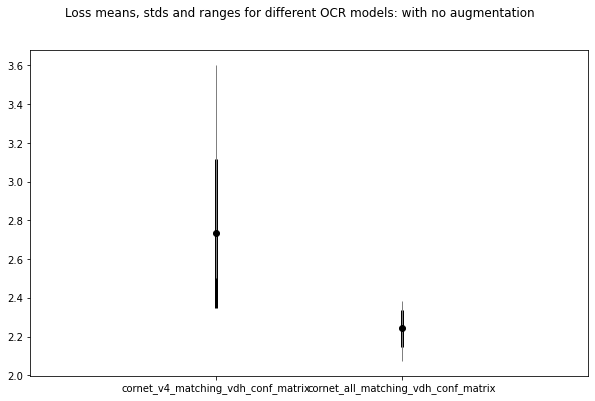

In [8]:
stats = plot_loss_stats(all_res, subtitle="with no augmentation")

Let's have a look at the results. Especially with the more plausible V4-and-on-finetuned model there is clear convergence on a specific parameter set. Note that the main difference is the unfortunate collapse of A and V to an I at loss of 2.6288.

Curiously, the shapes the fully finetuned model (i.e. with all layers unfrozen even in the initial finetuning with moderately augmented letters) converges on are quite illegible. We should not be surprised by errors, as even the lowest layers of that model were unfrozen during training with both moderate and very severe augmentations.

It is confidence-building that the more biologically plausible model also generates intuitively more legible results.

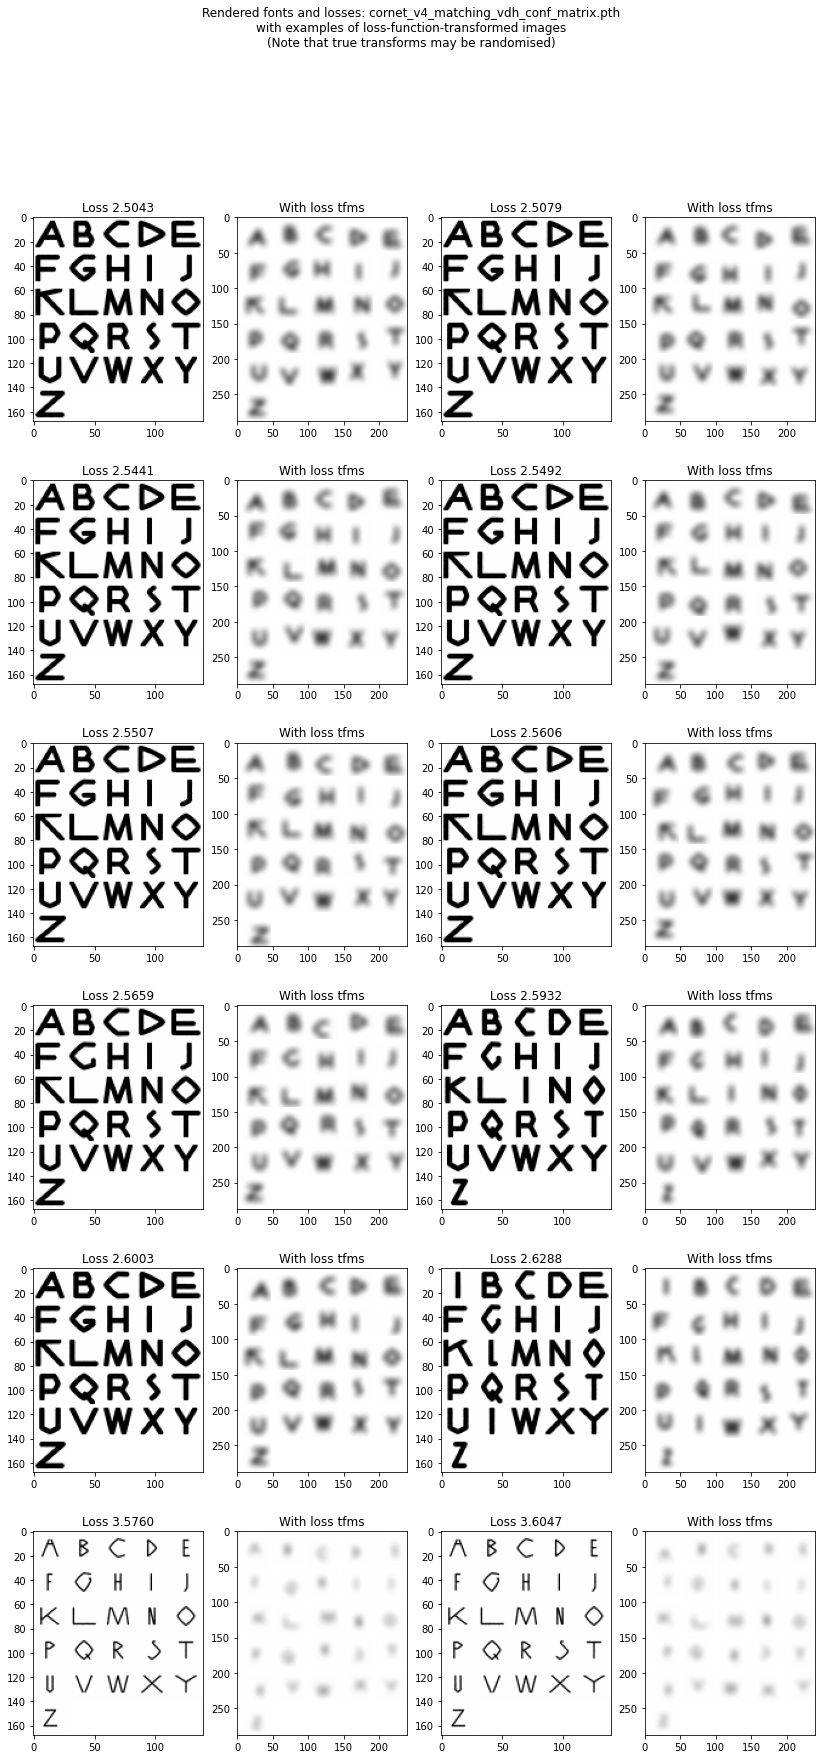

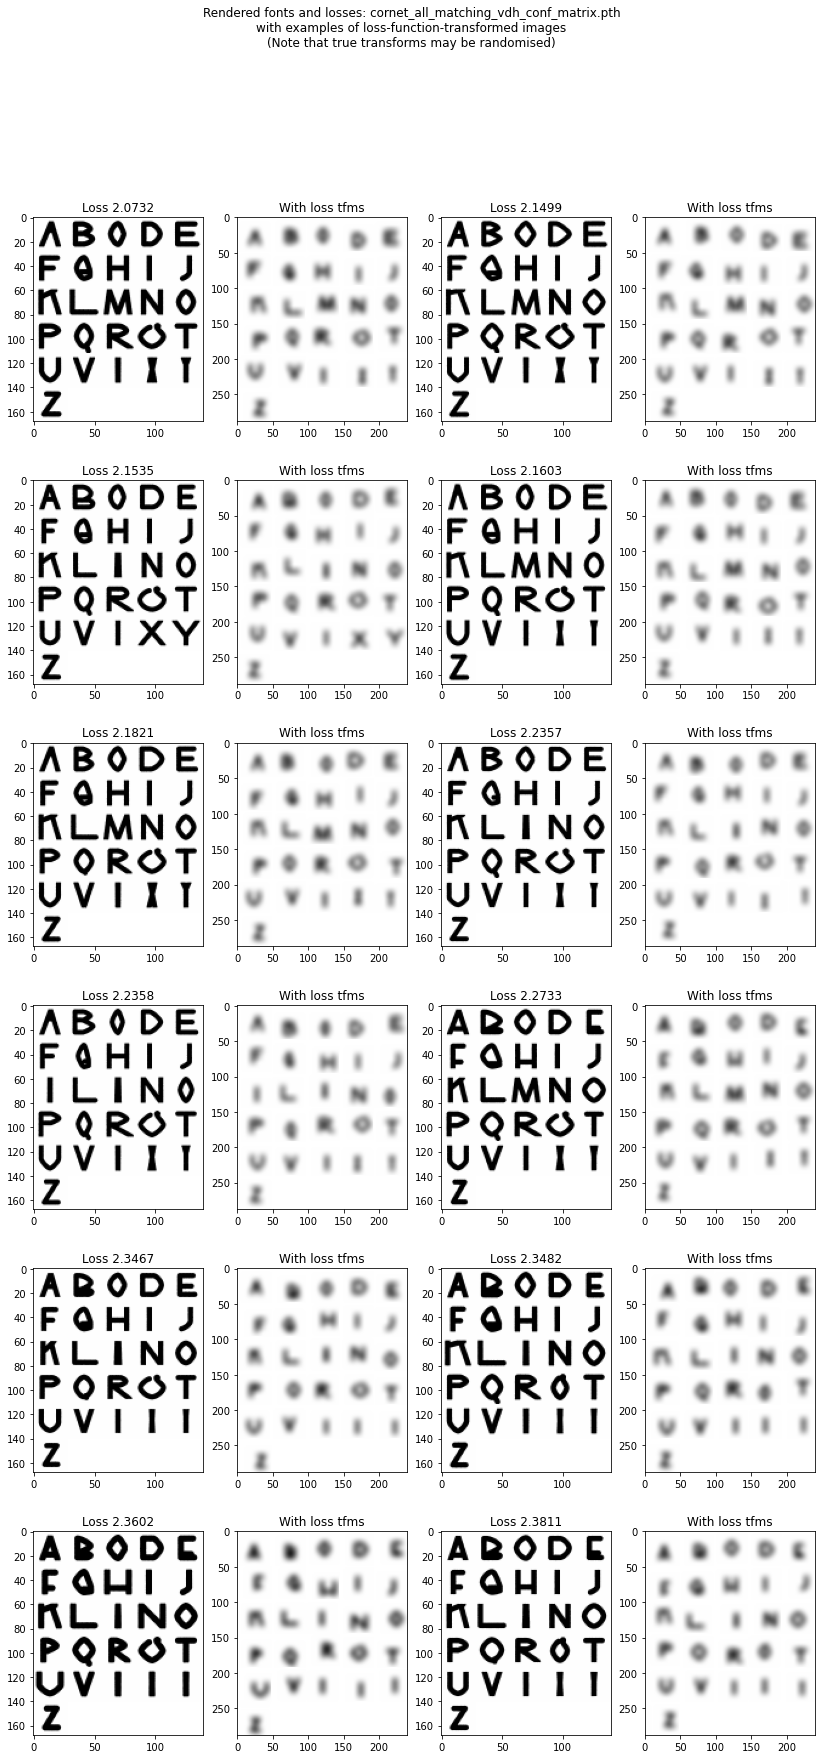

In [9]:
for ocr_fn,res in all_res.items():
    show_variation_renders(res, n=12, incl_tfms=True, title_sfx=ocr_fn)

Let's save the best parameters we found.

In [10]:
best = sorted(all_res["cornet_v4_matching_vdh_conf_matrix.pth"], key=lambda x: x["final_loss"])[0]
dump(best["final_params"], BEST_PARAMS_PATH)

## Experiment 3 Rerun 5: CORnet-Z, V4-Trained and Decoder-Finetuned


Rerun of the experiment with a hopefully final formulation of CORnet-Z:

1. Pretrained CORnet-Z base model
2. V4, IT and decoder layers trained with mixed font and handwritten text data
3. Decoder finetuned at 50% accuracy to match empirical confusion matrix (van der Heijden et al., 1984)

NB. On run c, we've changed the font model so that interpolated width has a minimum, non-zero value.

After a number of refiments, on run f we have made these changes:

1. Updated the font model parameter definitions so that:
   1. width has a minimum value
2. Edited the min values for `fancy_fit_ocr_variations` / `fancy_fit_ocr`:
   1. `min_width=.5`
   2. `min_height=.5`
   3. Edited `fancy_fit_ocr` so that these are ensured at each param reset
3. Edited `OCRLoss` to cater for the noise in the losses:
   1. `per_item_tfms`: Transformations are applied to each item in a batch individually to ensure variation for the following
   2. `per_category_avg`: Loss is calculated as the mean of the medians of each category's losses
   3. Increased the `LetterDL`'s `bs` to `26*3` to make use of the improvements above.
   4. Edited `get_learner` so that `TranslateAndPad` is no longer part of the `tfms` as it causes huge loss spreads (even 2.+ within one letter category's losses in a batch of 5!)
4. Now the loss variation is down to 2.739--2.777. Note, however, that the losses are higher than with `TranslateAndPad` (2.356--2.470)! If this causes issues, we may need to add that as an optimisable (category-specific) parameter as well...

With run g and h we've drastically changed the `fancy_fit_ocr` parameters.

* Many of the previous variations have a very high loss and their loss improvements are small or even negative.
* It seems our fitting schedule has been insufficient. The ones used by `fancy_fit_ocr` was:

    iters = 4,
    epochs = 25,
    lr = 1e-1,
    lr_factor = .9,

* However, we get good results with this schedule:

    – • loss 4.066805
    learn.fit_one_cycle(50, 0.035) • 3.361120	
    learn.fit_one_cycle(100, 0.03) • 2.9066294193267823
    learn.fit_one_cycle(100, 0.02) • 2.822362852096558
    learn.fit_one_cycle(100, 0.05) • 2.724664831161499
    learn.fit_one_cycle(100, 1.) • 2.636420965194702
    learn.fit_one_cycle(100, .85) • 2.6250888824462892
    learn.fit_one_cycle(100, .7) • 2.612827491760254
    learn.fit_one_cycle(100, .15) • 2.606103277206421
    learn.fit_one_cycle(100, .3) • 2.6036001205444337

* That is a huge number of epochs, however, so we'll settle for these args to `fancy_fit_ocr`:

    iters = 1,
    epochs = 400,
    lr = 1.,

### Create 35 Variations

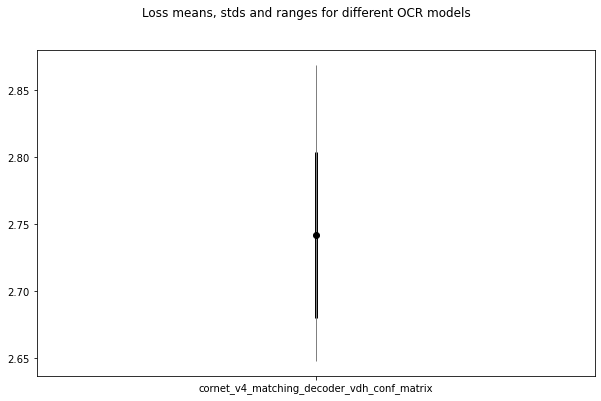

In [11]:
ocr_fn = EMPIRICAL_MODEL_2_FN
fn_suffix = "_exp1_5g"
fp = DUMP_FOLDER / f"font__{Path(ocr_fn).stem}{fn_suffix}all"
res = try_load(fp)
if res is None:
    res = fancy_fit_ocr_variations(ocr_fn,
                                   bs=26*3,
                                   fn_suffix=fn_suffix,
                                   variations=20,
                                   min_width=.5, # Let's add this to get rid of possible cul-de-sacs
                                   min_height=.5, # Let's add this to get rid of possible cul-de-sacs
                                   show_sample=False)
    # show_variation_renders(res, n=4, incl_tfms=True)
stats = plot_loss_stats({ocr_fn: res})

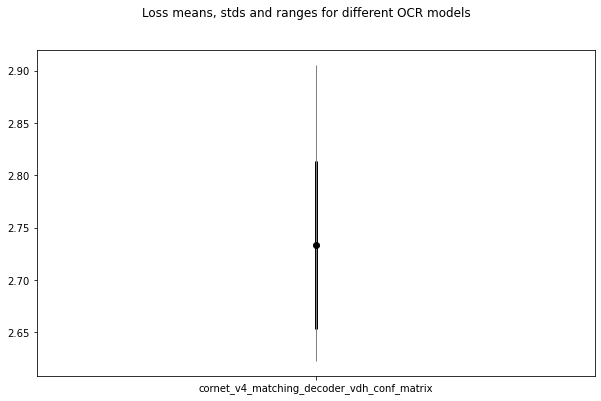

In [12]:
ocr_fn = EMPIRICAL_MODEL_2_FN
fn_suffix = "_exp1_5h"
fp = DUMP_FOLDER / f"font__{Path(ocr_fn).stem}{fn_suffix}all"
res_2 = try_load(fp)
if res_2 is None:
    res_2 = fancy_fit_ocr_variations(ocr_fn,
                                   bs=26*3,
                                   fn_suffix=fn_suffix,
                                   variations=20,
                                   min_width=.5, # Let's add this to get rid of possible cul-de-sacs
                                   min_height=.5, # Let's add this to get rid of possible cul-de-sacs
                                   show_sample=False)
    # show_variation_renders(res, n=4, incl_tfms=True)
stats = plot_loss_stats({ocr_fn: res_2})

### Analyse the Variations

Add per category losses and recalc combined ones.

In [36]:
ocr_fn = EMPIRICAL_MODEL_2_FN
fn_suffix = "_exp1_5g_and_h"
fp = DUMP_FOLDER / f"font__{Path(ocr_fn).stem}{fn_suffix}all"
res_all = try_load(fp)
if res_all is None:
    res_all = res + res_2
    recalculate_losses(res_all, iters=5)
    dump(res_all, fp)
res_all.sort(key=lambda o:o["final_loss"])
len(res_all)

35

Plot loss statistics.

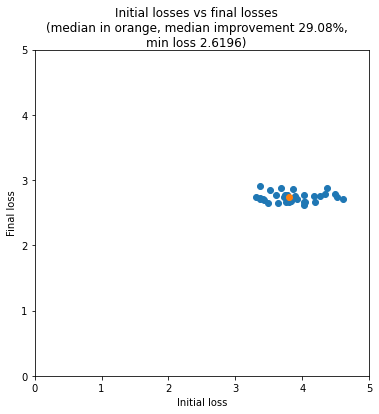

In [16]:
plot_variation_results(res_all)

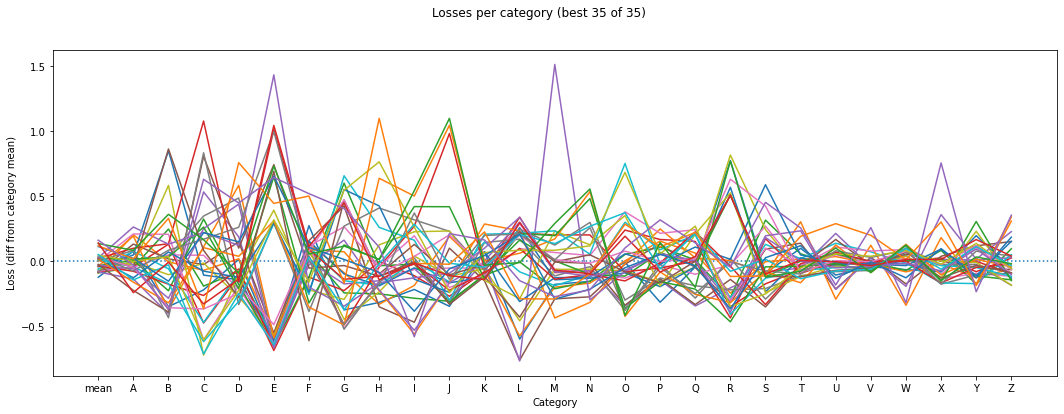

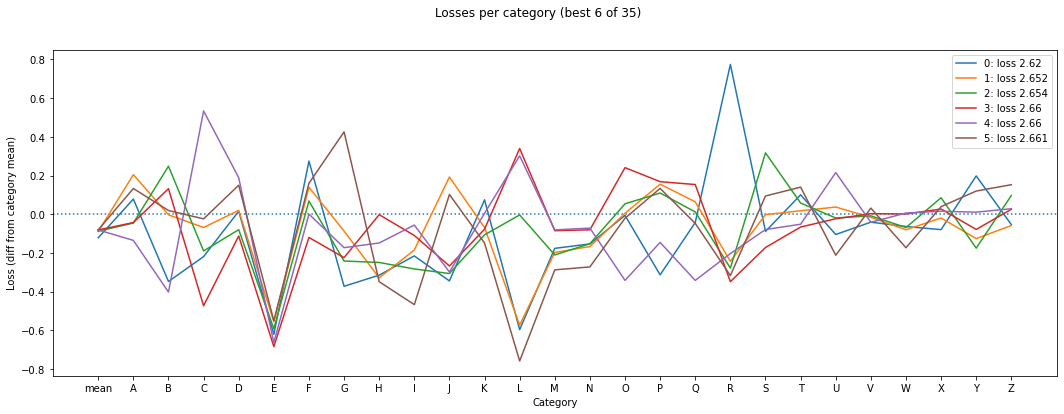

In [38]:
plot_per_category_losses(res_all)
plot_per_category_losses(res_all, plot_top_n=6)

Note how in even in the best version (blue), the loss for R is well above the mean. Let's have a look at which other letters are affected by the parameters that control R.

It seems that the huge loss for R represents a tradeoff, as its width is tied to B and P, which perform well, and the bowl height is an offset measured from the midline.

In [37]:
best_params = res_all[0]["final_params"]
# dump(best["final_params"], BEST_PARAMS_2_PATH)
{k:v for k,v in best_params.items() if param_affects(k, "R")}

{'Height': 3.577893018722534,
 'Midline': 1.513142704963684,
 'Stroke width': 0.4294508099555969,
 'Bowl curvature': 0.020773649215698242,
 'Width, BPR': 3.47896671295166,
 'Crossbar y offset, R': 0.1270902454853058,
 'Bowl aspect ratio, BPR': 0.7288516163825989,
 'Bowl distortion, BPR': 1.176390290260315,
 'Leg xp offset, R': -2.641275644302368,
 'Leg-bowl connection location, R': 2.7249693870544434,
 'Leg distortion, R': -1.0800236463546753}

### Train the Best Variation Further

Let's first see if it can be improved by basic training.

/Users/kallejarvenpaa/opt/miniconda3/envs/ai-font-p3.9/lib/python3.9/site-packages/fastai/learner.py:55: UserWarning: Could not load the optimizer state.
  if with_opt: warn("Could not load the optimizer state.")
/Users/kallejarvenpaa/Desktop/AI-fontti/aifont/aifont/fontlearner.py:2797: UserWarning: Using default input_shape: (28, 28)
  warn(f"Using default input_shape: {input_shape}")
/Users/kallejarvenpaa/Desktop/AI-fontti/aifont/aifont/fontlearner.py:680: UserWarning: Are you sure you want to define bs when using from_vocab?
  if x in kwargs and kwargs[x] is not None: warn(f"Are you sure you want to define {x} when using from_vocab?")


SuggestedLRs(valley=0.009120108559727669)

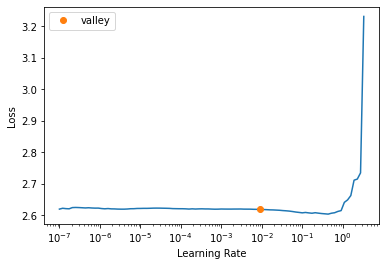

In [40]:
learn = get_learner(EMPIRICAL_MODEL_2_FN, bs=26*3)
learn.load_param_dict(best_params)
learn.lr_find()

In [41]:
learn.fit_one_cycle(100, .2)

Oh! We can still eke out some gains. And from the results we clearly see the font has improved.

2.539567995071411


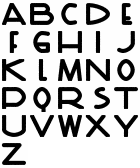

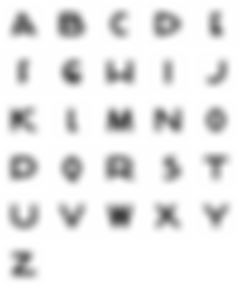

In [45]:
print(learn.get_current_loss(10))
display(learn.render_letters())
display(learn.render_letters(apply_tfms=True))

In [46]:
dump(learn.get_param_dict(), BEST_PARAMS_2_PATH)

SuggestedLRs(valley=0.00363078061491251)

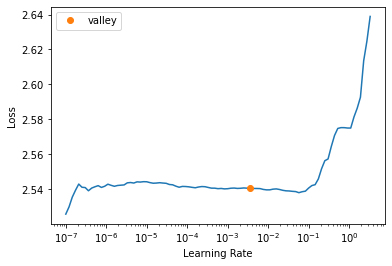

In [47]:
learn.lr_find()

In [48]:
learn.fit_one_cycle(100, .03)

2.534151887893677


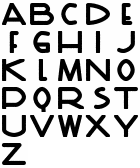

In [49]:
print(learn.get_current_loss(10))
display(learn.render_letters())

SuggestedLRs(valley=0.002511886414140463)

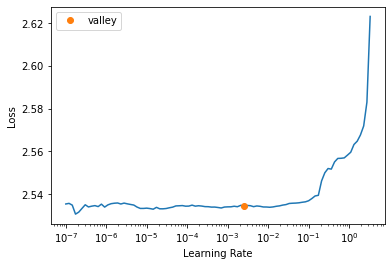

In [50]:
learn.lr_find()

Let's have a go at the low lr that keeps getting suggested.

In [51]:
learn.fit_one_cycle(100, 2e-7)

2.5315637826919555


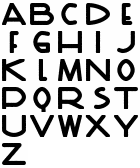

In [52]:
print(learn.get_current_loss(10))
display(learn.render_letters())

Seems like we've pretty much hit the bottom. Let's save these params and see whether further fitting one of the other shortlisted variations converges at some other set of parameter values.

In [53]:
dump(learn.get_param_dict(), BEST_PARAMS_2_PATH)

### Train Another Variation Further to See Where It Converges

Earlier, we trained the first variation. Let's have a look at the other variations in terms of renders and per-category losses.

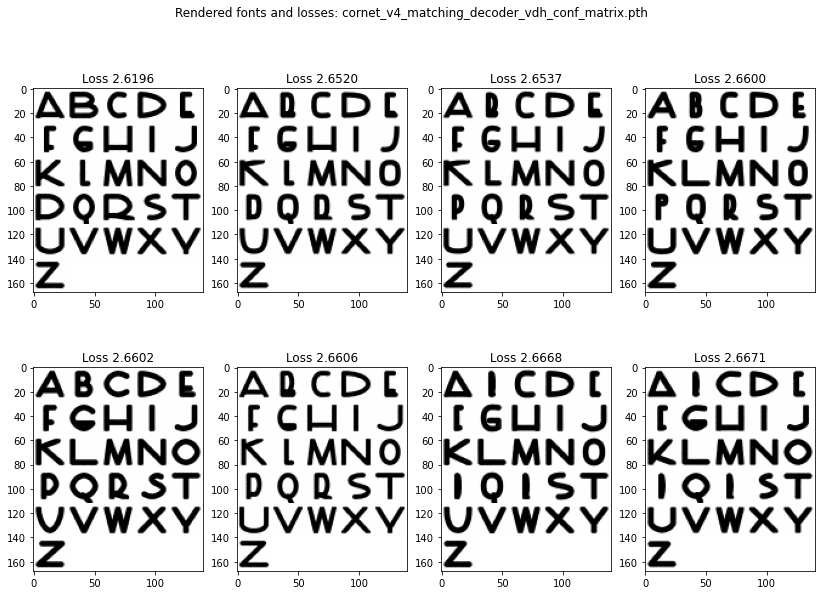

In [55]:
_ = show_variation_renders(res_all, n=8, incl_tfms=False, title_sfx=ocr_fn)

Let's try to find a variation that differs in the category losses from the first one.

In [62]:
bl = res_all[0]["per_category_loss"]
for i in range(1,10):
    o = res_all[i]
    diff = 0
    for k,v in o["per_category_loss"].items():
        diff += abs(bl[k] - v)
    print(f"{i}: {diff}")

1: 4.242274260520935
2: 5.040409934520722
3: 6.286070561408998
4: 5.924008822441102
5: 5.554532754421235
6: 5.594152033329008
7: 5.93118860721588
8: 3.341184353828428
9: 5.519556987285613


Variation 3 looks like a good candidate.

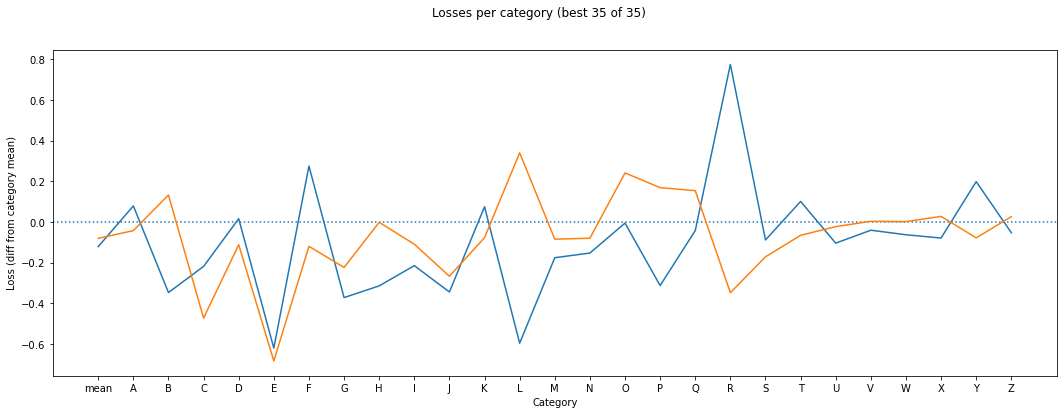

In [59]:
plot_per_category_losses(res_all, plot_idx=[0,3])

Looking at the renders, the fourth variation looks a like suitable one to try next.

/Users/kallejarvenpaa/opt/miniconda3/envs/ai-font-p3.9/lib/python3.9/site-packages/fastai/learner.py:55: UserWarning: Could not load the optimizer state.
  if with_opt: warn("Could not load the optimizer state.")
/Users/kallejarvenpaa/Desktop/AI-fontti/aifont/aifont/fontlearner.py:2797: UserWarning: Using default input_shape: (28, 28)
  warn(f"Using default input_shape: {input_shape}")
/Users/kallejarvenpaa/Desktop/AI-fontti/aifont/aifont/fontlearner.py:680: UserWarning: Are you sure you want to define bs when using from_vocab?
  if x in kwargs and kwargs[x] is not None: warn(f"Are you sure you want to define {x} when using from_vocab?")


SuggestedLRs(valley=0.010964781977236271)

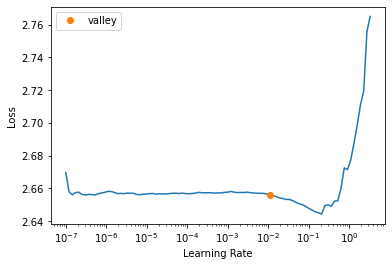

In [63]:
learn = None; gc.collect()
alt_params = res_all[3]["final_params"]
learn = get_learner(EMPIRICAL_MODEL_2_FN, bs=26*3)
learn.load_param_dict(alt_params)
learn.lr_find()

It seems we can use the same schedule as in the first case.

In [64]:
learn.fit_one_cycle(100, .2)

2.596253180503845


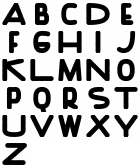

In [65]:
print(learn.get_current_loss(10))
display(learn.render_letters())

SuggestedLRs(valley=0.005248074419796467)

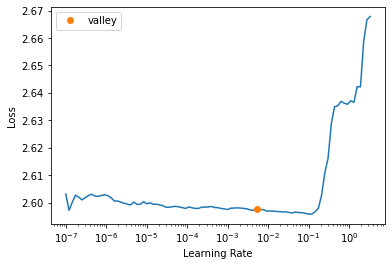

In [66]:
learn.lr_find()

In [67]:
learn.fit_one_cycle(100, .05)

2.591463255882263


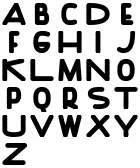

In [68]:
print(learn.get_current_loss(10))
display(learn.render_letters())

SuggestedLRs(valley=0.0003981071640737355)

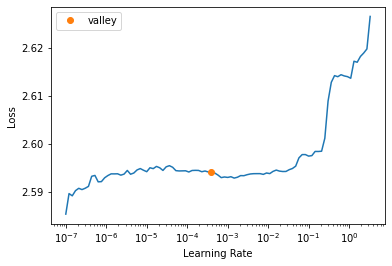

In [69]:
learn.lr_find()

In [70]:
learn.fit_one_cycle(50, 3e-7)

2.5952204704284667


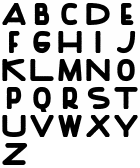

In [71]:
print(learn.get_current_loss(10))
display(learn.render_letters())

This seems the lowest we can go.

In [ ]:
dump(learn.get_param_dict(), ALT_PARAMS_PATH)

Let's compare it to the best params we got from variation 0.

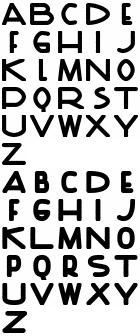

In [73]:
learn.load_param_dict(load(ALT_PARAMS_PATH))
alt_img = learn.render_letters()
learn.load_param_dict(load(BEST_PARAMS_2_PATH))
best_img = learn.render_letters()
image_grid((best_img, alt_img))

## Experiment 3 Rerun 6: CORnet-Z, V4-Trained, Decoder-Finetuned Without `translate_and_pad` + Translation Parameters

We noticed that `translate_and_pad` creates a lot of noice for the OCR.

Let's create new variations and do a bit of more automated finetuning.

### Initial Variation Training

In [24]:
ocr_fn = EMPIRICAL_MODEL_3_FN
learner_args = dict(
    ocr_fn=EMPIRICAL_MODEL_3_FN,
    bs=26*3,
    translate_and_pad=0.,
    param_specs=FONT_MATCHING_PARAM_SPECS, # Add translation parameters
)
fn_suffix = "_exp1_6c_" # _6b was without translation and with an older OCR model
fp = DUMP_FOLDER / f"font__{Path(ocr_fn).stem}{fn_suffix}all"
res = try_load(fp)
if res is None:
    res = fancy_fit_ocr_variations(fn_suffix=fn_suffix,
                                   variations=20,
                                #    iters=2, # New
                                #    epoch_increment=-250, # New
                                #    lr_factor=0.3, # New
                                   min_width=.5, # Let's add this to get rid of possible cul-de-sacs
                                   min_height=.5, # Let's add this to get rid of possible cul-de-sacs
                                   show_sample=False,
                                   **learner_args,
                                   )
    # show_variation_renders(res, n=4, incl_tfms=True)
stats = plot_loss_stats({ocr_fn: res}, loss_col="best_loss")

/Users/kallejarvenpaa/opt/miniconda3/envs/ai-font-p3.9/lib/python3.9/site-packages/fastai/callback/core.py:51: UserWarning: You are shadowing an attribute (logger) that exists in the learner. Use `self.learn.logger` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


## TODO: Above stopped at iter 19. Collect saved dumps and complete steps below.

In [ ]:
recalculate_losses(res, iters=5, **learner_args)
res.sort(key=lambda o:o["final_loss"])
dump(res, fp)

Recalculating loss for variation 1 of 20...g_decoder_vdh_conf_matrix_no_trapad.pth                                      


/Users/kallejarvenpaa/opt/miniconda3/envs/ai-font-p3.9/lib/python3.9/site-packages/fastai/learner.py:55: UserWarning: Could not load the optimizer state.
  if with_opt: warn("Could not load the optimizer state.")
/Users/kallejarvenpaa/Desktop/AI-fontti/aifont/aifont/fontlearner.py:2797: UserWarning: Using default input_shape: (28, 28)
  warn(f"Using default input_shape: {input_shape}")
/Users/kallejarvenpaa/Desktop/AI-fontti/aifont/aifont/fontlearner.py:680: UserWarning: Are you sure you want to define bs when using from_vocab?
  if x in kwargs and kwargs[x] is not None: warn(f"Are you sure you want to define {x} when using from_vocab?")


Recalculating loss for variation 2 of 20...
Recalculating loss for variation 3 of 20...
Recalculating loss for variation 4 of 20...
Recalculating loss for variation 5 of 20...
Recalculating loss for variation 6 of 20...
Recalculating loss for variation 7 of 20...
Recalculating loss for variation 8 of 20...
Recalculating loss for variation 9 of 20...
Recalculating loss for variation 10 of 20...
Recalculating loss for variation 11 of 20...
Recalculating loss for variation 12 of 20...
Recalculating loss for variation 13 of 20...
Recalculating loss for variation 14 of 20...
Recalculating loss for variation 15 of 20...
Recalculating loss for variation 16 of 20...
Recalculating loss for variation 17 of 20...
Recalculating loss for variation 18 of 20...
Recalculating loss for variation 19 of 20...
Recalculating loss for variation 20 of 20...


### Further Fine-Tuning of Variations

In [ ]:
for r in res:
    learn = None; gc.collect()
    learn = get_learner(**learner_args)
    learn.load_param_dict(r["final_params"])
    learn.fit_one_cycle(150, .3)
    r["finetuned_params_150"] = learn.get_param_dict()
    l = learn.get_current_loss(10)
    r["loss_at_150"] = l
    dump(res, fp)
    if l < r["final_loss"]:
        learn.fit_one_cycle(100, .03)
        r["finetuned_params_250"] = learn.get_param_dict()
        r["loss_at_250"] = learn.get_current_loss(10)
        dump(res, fp)

/Users/kallejarvenpaa/opt/miniconda3/envs/ai-font-p3.9/lib/python3.9/site-packages/fastai/learner.py:55: UserWarning: Could not load the optimizer state.
  if with_opt: warn("Could not load the optimizer state.")
/Users/kallejarvenpaa/Desktop/AI-fontti/aifont/aifont/fontlearner.py:2797: UserWarning: Using default input_shape: (28, 28)
  warn(f"Using default input_shape: {input_shape}")
/Users/kallejarvenpaa/Desktop/AI-fontti/aifont/aifont/fontlearner.py:680: UserWarning: Are you sure you want to define bs when using from_vocab?
  if x in kwargs and kwargs[x] is not None: warn(f"Are you sure you want to define {x} when using from_vocab?")


Look at the improvements yielded by finetuning and select the best parameters.

In [ ]:
for i,r in enumerate(res):
    fl = r["final_loss"]
    l2 = r["loss_at_150"]
    l3 = r["loss_at_250"] if "loss_at_250" in r else 9.999
    ld  = fl - l2
    ld2 = l2 - l3
    print(f"Res {i}: loss improvement {ld:.4} • {ld2:.4} | {fl:.4} => {l2:.4} => {l3:.4}")
    ml = min(fl, l2, l3)
    if   ml == fl: bp = r["final_params"]
    elif ml == l2: bp = r["finetuned_params_150"]
    elif ml == l3: bp = r["finetuned_params_250"]
    else: raise Exception("Unknown loss")
    r["best_loss"] = ml
    r["best_params"] = bp
dump(res, fp)

Res 0: loss improvement 0.1247 • 0.008843 | 3.017 => 2.892 => 2.883
Res 1: loss improvement 0.1281 • 0.003948 | 3.012 => 2.884 => 2.88
Res 2: loss improvement 0.149 • 0.008891 | 3.032 => 2.883 => 2.874
Res 3: loss improvement 0.296 • 0.01794 | 3.209 => 2.913 => 2.895
Res 4: loss improvement 0.2507 • -0.0008865 | 3.156 => 2.905 => 2.906
Res 5: loss improvement 0.1064 • 0.0001633 | 3.022 => 2.916 => 2.916
Res 6: loss improvement 0.1969 • 0.01072 | 3.13 => 2.933 => 2.923
Res 7: loss improvement 0.1041 • 0.004772 | 3.048 => 2.944 => 2.939
Res 8: loss improvement 0.2428 • 0.006239 | 3.192 => 2.949 => 2.942
Res 9: loss improvement 0.2309 • 0.002586 | 3.195 => 2.964 => 2.961
Res 10: loss improvement 0.361 • 0.009043 | 3.348 => 2.987 => 2.978
Res 11: loss improvement 0.1068 • 0.01364 | 3.098 => 2.991 => 2.978
Res 12: loss improvement 0.2342 • 0.004343 | 3.244 => 3.009 => 3.005
Res 13: loss improvement 0.1936 • -0.000613 | 3.223 => 3.029 => 3.03
Res 14: loss improvement 0.1568 • 0.01773 | 3.201

Reorder the results and render.

In [ ]:
res.sort(key=lambda o:o["best_loss"])
dump(res, fp)

### Analyse the Results

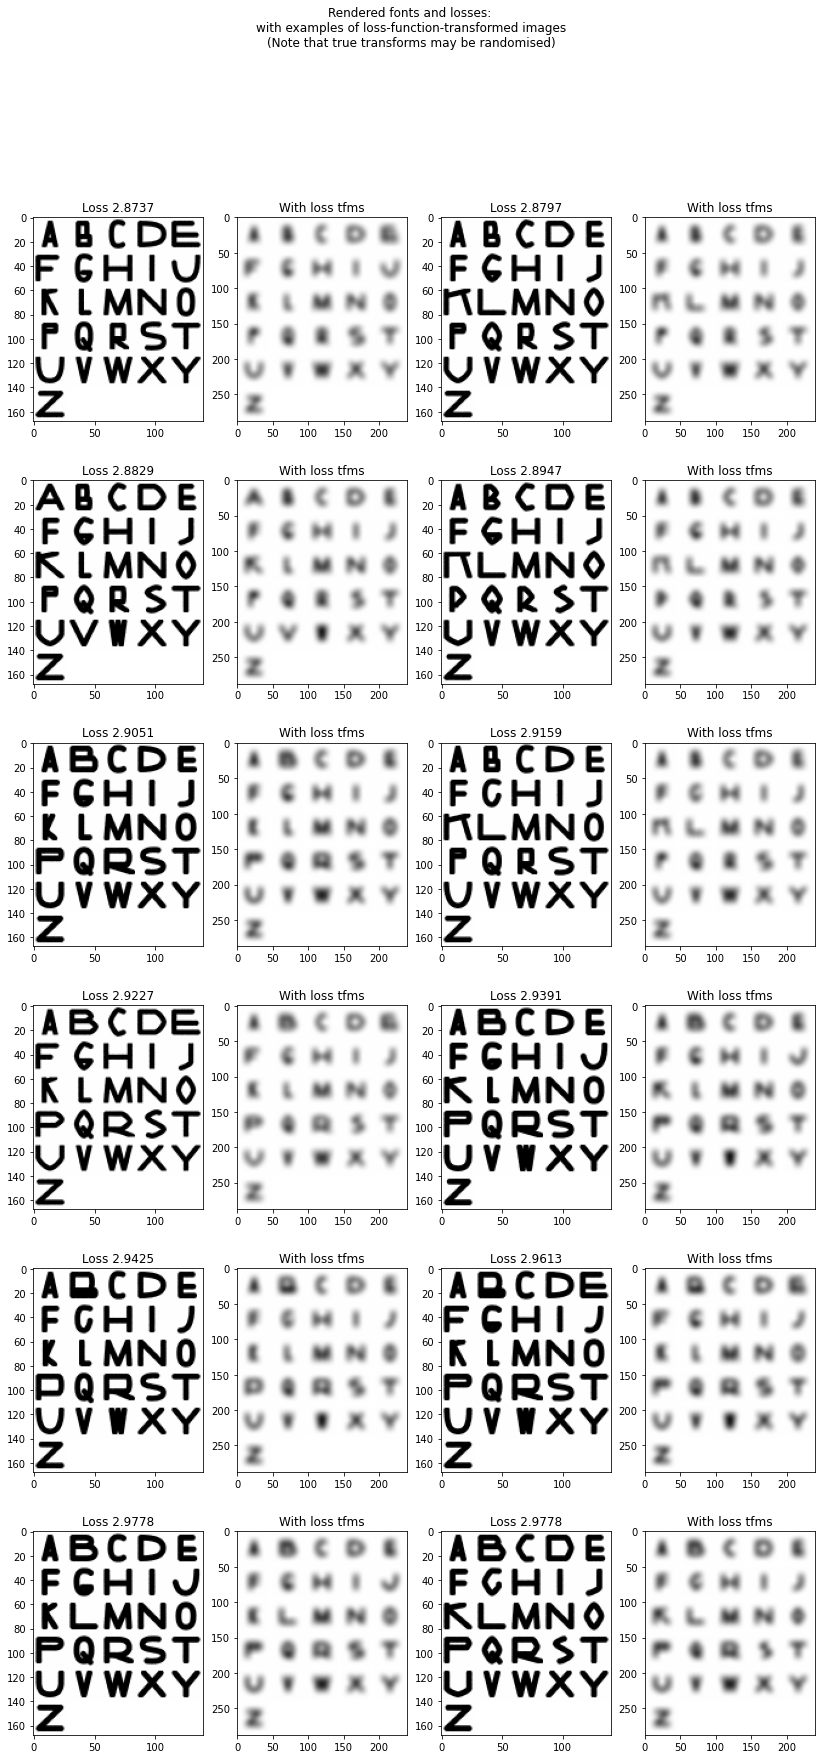

In [ ]:
_ = show_variation_renders(
    res, 
    incl_tfms=True, 
    rerender=True,
    learner=get_learner(**learner_args), 
    loss_col="best_loss",
    param_col="best_params"
    )

The first four results are very close in loss values. Let's have a closer look at their losses. We need to recalculate per category losses with the best parameters.

In [ ]:
recalculate_losses(res, incl_loss=False, param_col="best_params", cat_loss_col="best_per_category_loss", 
                   iters=5, **learner_args)
dump(res, fp)

Recalculating loss for variation 1 of 20...g_decoder_vdh_conf_matrix_no_trapad.pth                                      


/Users/kallejarvenpaa/opt/miniconda3/envs/ai-font-p3.9/lib/python3.9/site-packages/fastai/learner.py:55: UserWarning: Could not load the optimizer state.
  if with_opt: warn("Could not load the optimizer state.")
/Users/kallejarvenpaa/Desktop/AI-fontti/aifont/aifont/fontlearner.py:2797: UserWarning: Using default input_shape: (28, 28)
  warn(f"Using default input_shape: {input_shape}")
/Users/kallejarvenpaa/Desktop/AI-fontti/aifont/aifont/fontlearner.py:680: UserWarning: Are you sure you want to define bs when using from_vocab?
  if x in kwargs and kwargs[x] is not None: warn(f"Are you sure you want to define {x} when using from_vocab?")


Recalculating loss for variation 2 of 20...
Recalculating loss for variation 3 of 20...
Recalculating loss for variation 4 of 20...
Recalculating loss for variation 5 of 20...
Recalculating loss for variation 6 of 20...
Recalculating loss for variation 7 of 20...
Recalculating loss for variation 8 of 20...
Recalculating loss for variation 9 of 20...
Recalculating loss for variation 10 of 20...
Recalculating loss for variation 11 of 20...
Recalculating loss for variation 12 of 20...
Recalculating loss for variation 13 of 20...
Recalculating loss for variation 14 of 20...
Recalculating loss for variation 15 of 20...
Recalculating loss for variation 16 of 20...
Recalculating loss for variation 17 of 20...
Recalculating loss for variation 18 of 20...
Recalculating loss for variation 19 of 20...
Recalculating loss for variation 20 of 20...


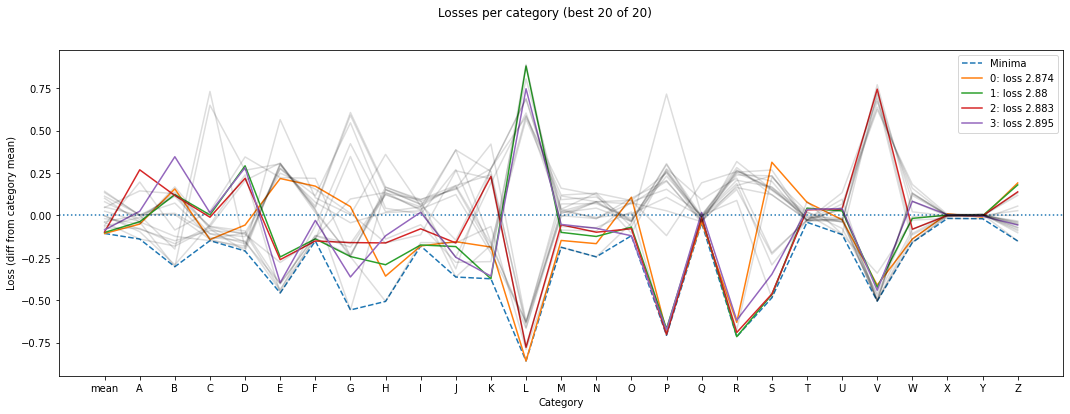

In [ ]:
plot_per_category_losses(res, plot_idx=range(4), plot_rest=True, 
                         loss_col="best_loss", cat_loss_col="best_per_category_loss")

### Merge Best Parameters From the Variations

Let's see what happens if we combine the best params found for each of the letters (see the dashed line in the loss graph above).

In [ ]:
cat_loss_col = "best_per_category_loss"
param_col = "best_params"
merged_params = merge_best_parameters(res, param_col=param_col, cat_loss_col=cat_loss_col,
                                      min_improvement=.1)
learn = None; gc.collect()
learn = get_learner(**learner_args)
learn.load_param_dict(merged_params)
l1 = res[0]["best_loss"]
l2 = learn.get_current_loss(10)
print(f"Loss improvement: {l1 - l2:.4} • {l1:.4} => {l2:.4}")


Change 'Width, D' from 2.567 => 2.569
Change 'Width, EF' from 1.5 => -0.9529
Change 'Width, J' from 2.562 => 0.5058
Change 'Width, K' from -0.7877 => 2.569
Change 'Width, S' from 1.49 => 3.219
Change 'Width, TZ' from 2.599 => 2.568
Change 'Width n difference from E, F' from 0.7962 => -3.871
Change 'Width n difference from O, G' from -3.958 => -0.7218
Change 'Crossbar y offset, B' from 0.7132 => -0.9646
Change 'Crossbar y offset, G' from 1.655 => 1.366
Change 'Crossbar length, G' from 1.362 => 2.702
Change 'Bar stem height, G' from -3.459 => -2.745
Change 'Bowl aspect ratio, D' from -1.661 => -2.457
Change 'Bowl aspect ratio, J' from -1.695 => 2.637
Change 'Bowl distortion, J' from -3.865 => 2.658
Change 'Upper bowl xn offset, B' from 3.893 => 3.069
Change 'Upper width n difference, E' from 2.874 => -1.964
Change 'Upper bowl ratio to lower, S' from 2.875 => 1.137
Change 'Upper bowl xp offset, S' from -2.67 => -0.2152
Change 'Upper width n difference, Z' from -1.309 => -3.612
Change 'Mid

We got a tiny improvement. Let's save these params as the best ones.

In [ ]:
best_params = learn.get_param_dict()
dump(best_params, BEST_PARAMS_3_PATH)

### Fine-Tuning the Merged Parameters

Out of curiosity, let's see if we can still train the model further.

SuggestedLRs(valley=0.019054606556892395)

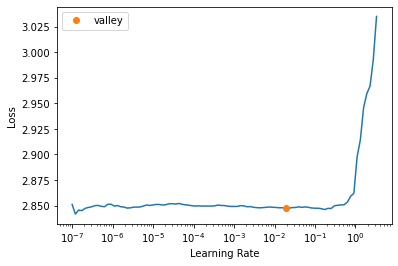

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(100, .02)
clear()
print(l2, learn.get_current_loss(10))

2.8479586839675903 2.8273757696151733


We could still make some improvements.

In [ ]:
best_params = learn.get_param_dict()
learn.fit_one_cycle(100, .015)
clear()
print(2.8273757696151733, learn.get_current_loss(10))

2.8273757696151733 2.8268141984939574


That was the best we could get to even though LR finder suggest gains with very low rates. These were not realised, however.

SuggestedLRs(valley=0.00363078061491251)

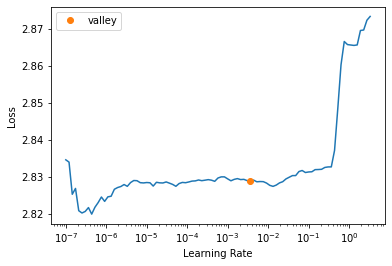

In [112]:
best_params = learn.get_param_dict()
dump(best_params, BEST_PARAMS_3_PATH)
learn.lr_find()

In [114]:
learn.fit_one_cycle(100, 1e-6)
clear()
print(2.826915812492371, learn.get_current_loss(10))

2.826915812492371 2.828923559188843


### Analyse the Final Result

Let's prepend the best params we got to the results.

In [116]:
best_res = dict(best_params = load(BEST_PARAMS_3_PATH))
recalculate_losses([best_res], incl_loss=True,
                   loss_col="best_loss", param_col="best_params", cat_loss_col="best_per_category_loss", 
                   iters=5, **learner_args)
res = [best_res] + res
dump(res, fp)

Recalculating loss for variation 1 of 1...ng_decoder_vdh_conf_matrix_no_trapad.pth                                      


/Users/kallejarvenpaa/opt/miniconda3/envs/ai-font-p3.9/lib/python3.9/site-packages/fastai/learner.py:55: UserWarning: Could not load the optimizer state.
  if with_opt: warn("Could not load the optimizer state.")
/Users/kallejarvenpaa/Desktop/AI-fontti/aifont/aifont/fontlearner.py:2797: UserWarning: Using default input_shape: (28, 28)
  warn(f"Using default input_shape: {input_shape}")
/Users/kallejarvenpaa/Desktop/AI-fontti/aifont/aifont/fontlearner.py:680: UserWarning: Are you sure you want to define bs when using from_vocab?
  if x in kwargs and kwargs[x] is not None: warn(f"Are you sure you want to define {x} when using from_vocab?")


Finally, let's have a look at the final result. In the picture below, the first variation is the merged one and the second, the initial best result.

/Users/kallejarvenpaa/opt/miniconda3/envs/ai-font-p3.9/lib/python3.9/site-packages/fastai/learner.py:55: UserWarning: Could not load the optimizer state.
  if with_opt: warn("Could not load the optimizer state.")
/Users/kallejarvenpaa/Desktop/AI-fontti/aifont/aifont/fontlearner.py:2797: UserWarning: Using default input_shape: (28, 28)
  warn(f"Using default input_shape: {input_shape}")
/Users/kallejarvenpaa/Desktop/AI-fontti/aifont/aifont/fontlearner.py:680: UserWarning: Are you sure you want to define bs when using from_vocab?
  if x in kwargs and kwargs[x] is not None: warn(f"Are you sure you want to define {x} when using from_vocab?")


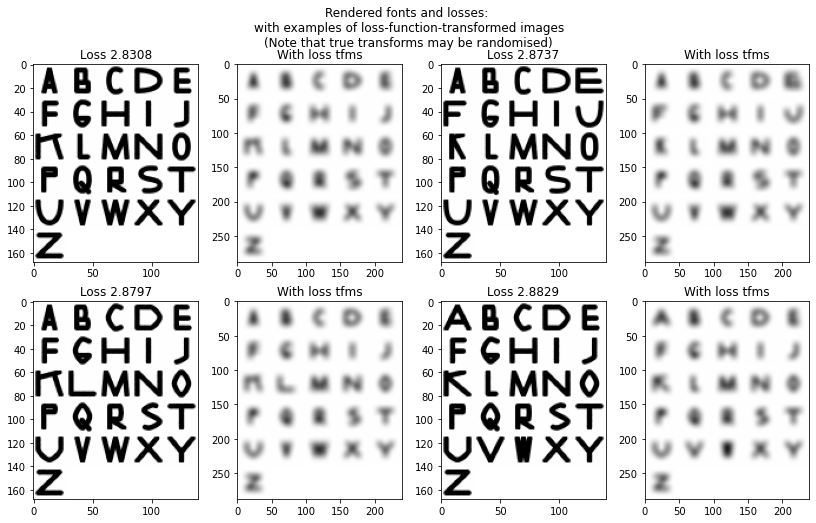

In [124]:
_ = show_variation_renders(
    res, 
    incl_tfms=True, 
    rerender=True,
    learner=get_learner(**learner_args), 
    loss_col="best_loss",
    param_col="best_params",
    n=4,
    n_cols=4,
    )

## ERROR!!! Experiment 3 Rerun 7: 6 + Frozen Stroke Width

Optimise the font with the Stroke Width parameter set to one matching Arial.

> ERROR! Stroke width should've been -0.7592605948448181. Rerun needed.

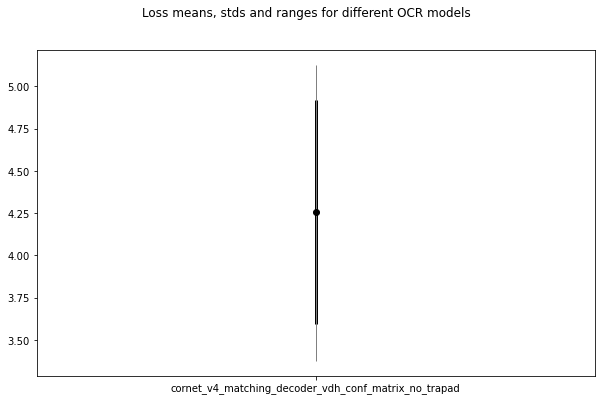

In [41]:
ocr_fn = EMPIRICAL_MODEL_3_FN
learner_args = dict(
    ocr_fn=EMPIRICAL_MODEL_3_FN,
    bs=26*3,
    translate_and_pad=0.
)
frozen_params = {"Stroke width": -1.0305887460708618}
fn_suffix = "_exp1_7"
fp = DUMP_FOLDER / f"font__{Path(ocr_fn).stem}{fn_suffix}all"
res = try_load(fp)
if res is None:
    res = fancy_fit_ocr_variations(fn_suffix=fn_suffix,
                                   variations=20,
                                #    iters=2, # New
                                #    epoch_increment=-250, # New
                                #    lr_factor=0.3, # New
                                   min_width=.5, # Let's add this to get rid of possible cul-de-sacs
                                   min_height=.5, # Let's add this to get rid of possible cul-de-sacs
                                   show_sample=False,
                                   frozen_params=frozen_params,
                                   **learner_args,
                                   )
    # show_variation_renders(res, n=4, incl_tfms=True)
stats = plot_loss_stats({ocr_fn: res})

In [42]:
recalculate_losses(res, iters=5, **learner_args)
res.sort(key=lambda o:o["final_loss"])
dump(res, fp)

Recalculating loss for variation 1 of 20...g_decoder_vdh_conf_matrix_no_trapad.pth                                      


/Users/kallejarvenpaa/opt/miniconda3/envs/ai-font-p3.9/lib/python3.9/site-packages/fastai/learner.py:55: UserWarning: Could not load the optimizer state.
  if with_opt: warn("Could not load the optimizer state.")
/Users/kallejarvenpaa/Desktop/AI-fontti/aifont/aifont/fontlearner.py:2797: UserWarning: Using default input_shape: (28, 28)
  warn(f"Using default input_shape: {input_shape}")
/Users/kallejarvenpaa/Desktop/AI-fontti/aifont/aifont/fontlearner.py:680: UserWarning: Are you sure you want to define bs when using from_vocab?
  if x in kwargs and kwargs[x] is not None: warn(f"Are you sure you want to define {x} when using from_vocab?")


Recalculating loss for variation 2 of 20...
Recalculating loss for variation 3 of 20...
Recalculating loss for variation 4 of 20...
Recalculating loss for variation 5 of 20...
Recalculating loss for variation 6 of 20...
Recalculating loss for variation 7 of 20...
Recalculating loss for variation 8 of 20...
Recalculating loss for variation 9 of 20...
Recalculating loss for variation 10 of 20...
Recalculating loss for variation 11 of 20...
Recalculating loss for variation 12 of 20...
Recalculating loss for variation 13 of 20...
Recalculating loss for variation 14 of 20...
Recalculating loss for variation 15 of 20...
Recalculating loss for variation 16 of 20...
Recalculating loss for variation 17 of 20...
Recalculating loss for variation 18 of 20...
Recalculating loss for variation 19 of 20...
Recalculating loss for variation 20 of 20...


In [43]:
def _prepare_learner(learn) -> None:
    for k, v in frozen_params.items():
        learn.set_param(k, v)
    learn.freeze_params(list(frozen_params.keys()))

In [44]:
for r in res:
    learn = None; gc.collect()
    learn = get_learner(**learner_args)
    learn.load_param_dict(r["final_params"])
    _prepare_learner(learn) # Important
    learn.fit_one_cycle(150, .3)
    r["finetuned_params_150"] = learn.get_param_dict()
    l = learn.get_current_loss(10)
    r["loss_at_150"] = l
    dump(res, fp)
    if l < r["final_loss"]:
        learn.fit_one_cycle(100, .03)
        r["finetuned_params_250"] = learn.get_param_dict()
        r["loss_at_250"] = learn.get_current_loss(10)
        dump(res, fp)

In [45]:
for i,r in enumerate(res):
    fl = r["final_loss"]
    l2 = r["loss_at_150"]
    l3 = r["loss_at_250"] if "loss_at_250" in r else 9.999
    ld  = fl - l2
    ld2 = l2 - l3
    print(f"Res {i}: loss improvement {ld:.4} • {ld2:.4} | {fl:.4} => {l2:.4} => {l3:.4}")
    ml = min(fl, l2, l3)
    if   ml == fl: bp = r["final_params"]
    elif ml == l2: bp = r["finetuned_params_150"]
    elif ml == l3: bp = r["finetuned_params_250"]
    else: raise Exception("Unknown loss")
    r["best_loss"] = ml
    r["best_params"] = bp
dump(res, fp)

Res 0: loss improvement 0.05907 • 0.006744 | 3.388 => 3.329 => 3.322
Res 1: loss improvement 0.1369 • 0.004774 | 3.497 => 3.36 => 3.355
Res 2: loss improvement 0.1473 • 0.01679 | 3.527 => 3.379 => 3.363
Res 3: loss improvement 0.1716 • -0.0002774 | 3.542 => 3.371 => 3.371
Res 4: loss improvement 0.1635 • 0.003803 | 3.546 => 3.383 => 3.379
Res 5: loss improvement 0.1454 • 0.003271 | 3.585 => 3.44 => 3.436
Res 6: loss improvement 0.1811 • 0.008969 | 3.585 => 3.404 => 3.395
Res 7: loss improvement 0.1285 • 0.005584 | 3.664 => 3.536 => 3.53
Res 8: loss improvement 0.2279 • 0.01533 | 3.672 => 3.444 => 3.428
Res 9: loss improvement 0.9422 • 0.009675 | 4.256 => 3.314 => 3.304
Res 10: loss improvement 1.261 • 0.01133 | 4.587 => 3.327 => 3.316
Res 11: loss improvement 1.331 • 0.02402 | 4.666 => 3.335 => 3.311
Res 12: loss improvement 1.462 • 0.01653 | 4.836 => 3.374 => 3.358
Res 13: loss improvement 1.4 • -0.002286 | 4.86 => 3.46 => 3.462
Res 14: loss improvement 1.499 • 0.004317 | 4.885 => 3.3

In [46]:
res.sort(key=lambda o:o["best_loss"])
dump(res, fp)

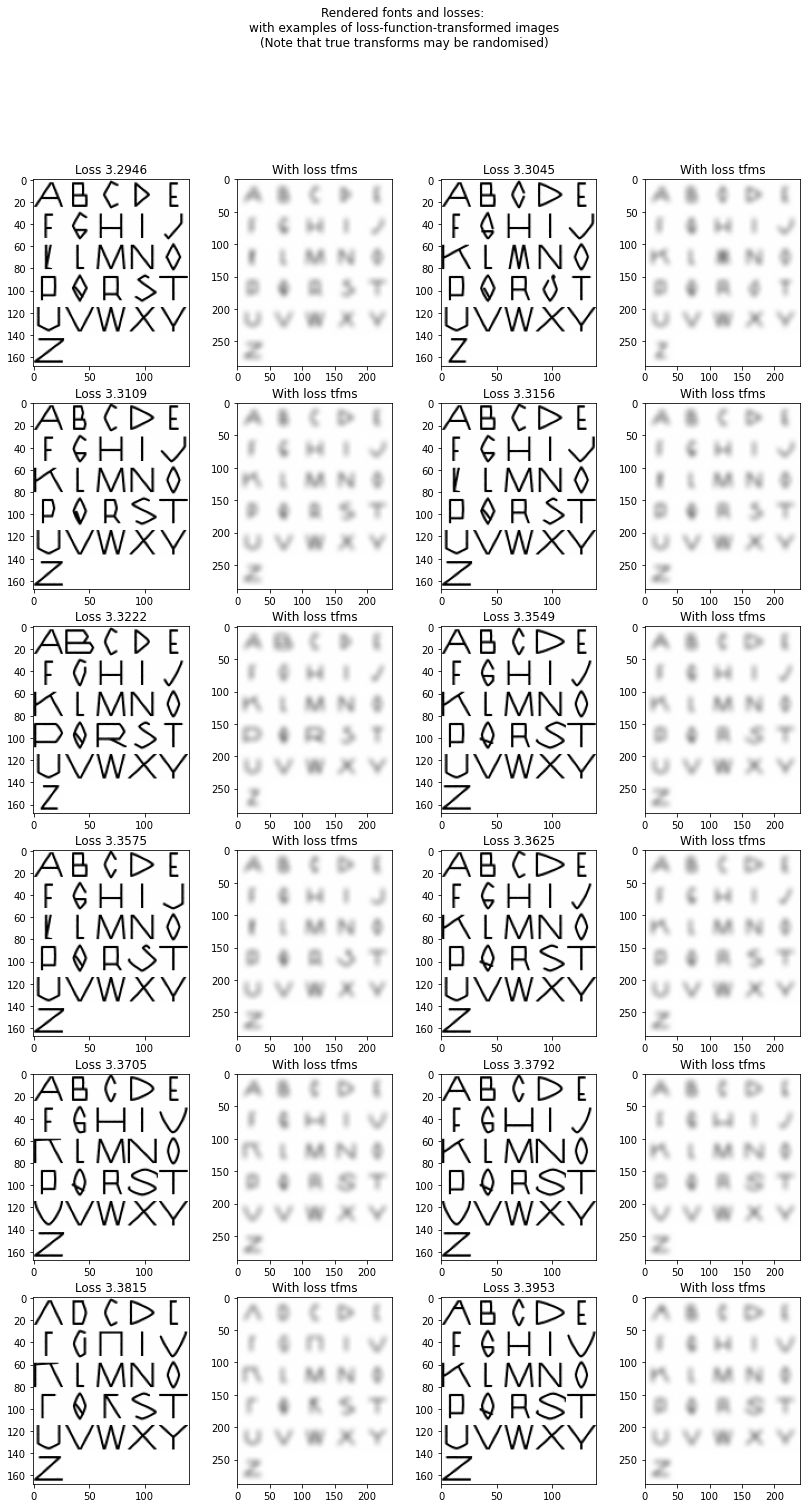

In [47]:
_ = show_variation_renders(
    res, 
    incl_tfms=True, 
    rerender=True,
    learner=get_learner(**learner_args), 
    loss_col="best_loss",
    param_col="best_params"
    )

In [48]:
recalculate_losses(res, incl_loss=False, param_col="best_params", cat_loss_col="best_per_category_loss", 
                   iters=5, **learner_args)
dump(res, fp)

Recalculating loss for variation 1 of 20...g_decoder_vdh_conf_matrix_no_trapad.pth                                      


/Users/kallejarvenpaa/opt/miniconda3/envs/ai-font-p3.9/lib/python3.9/site-packages/fastai/learner.py:55: UserWarning: Could not load the optimizer state.
  if with_opt: warn("Could not load the optimizer state.")
/Users/kallejarvenpaa/Desktop/AI-fontti/aifont/aifont/fontlearner.py:2797: UserWarning: Using default input_shape: (28, 28)
  warn(f"Using default input_shape: {input_shape}")
/Users/kallejarvenpaa/Desktop/AI-fontti/aifont/aifont/fontlearner.py:680: UserWarning: Are you sure you want to define bs when using from_vocab?
  if x in kwargs and kwargs[x] is not None: warn(f"Are you sure you want to define {x} when using from_vocab?")


Recalculating loss for variation 2 of 20...
Recalculating loss for variation 3 of 20...
Recalculating loss for variation 4 of 20...
Recalculating loss for variation 5 of 20...
Recalculating loss for variation 6 of 20...
Recalculating loss for variation 7 of 20...
Recalculating loss for variation 8 of 20...
Recalculating loss for variation 9 of 20...
Recalculating loss for variation 10 of 20...
Recalculating loss for variation 11 of 20...
Recalculating loss for variation 12 of 20...
Recalculating loss for variation 13 of 20...
Recalculating loss for variation 14 of 20...
Recalculating loss for variation 15 of 20...
Recalculating loss for variation 16 of 20...
Recalculating loss for variation 17 of 20...
Recalculating loss for variation 18 of 20...
Recalculating loss for variation 19 of 20...
Recalculating loss for variation 20 of 20...


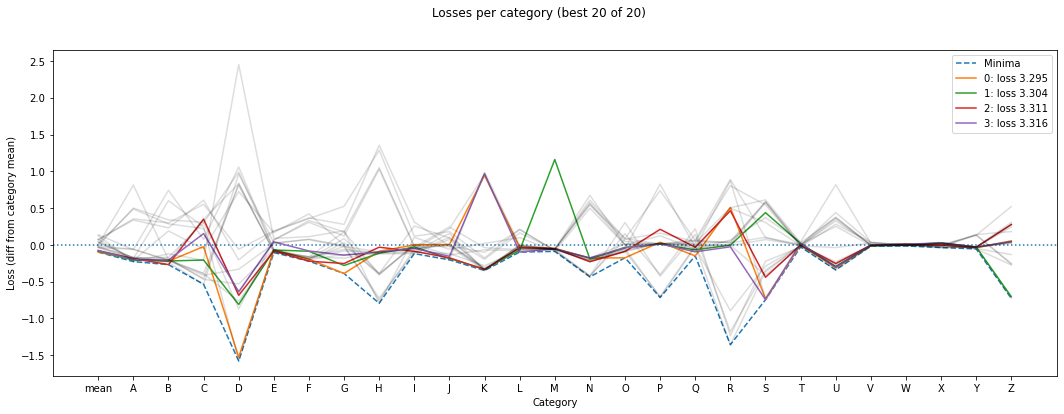

In [49]:
plot_per_category_losses(res, plot_idx=range(4), plot_rest=True, 
                         loss_col="best_loss", cat_loss_col="best_per_category_loss")

In [52]:
cat_loss_col = "best_per_category_loss"
param_col = "best_params"
merged_params = merge_best_parameters(res, param_col=param_col, cat_loss_col=cat_loss_col,
                                      min_improvement=.1)
learn = None; gc.collect()
learn = get_learner(**learner_args)
learn.load_param_dict(merged_params)
l1 = res[0]["best_loss"]
l2 = learn.get_current_loss(10)
print(f"Loss improvement: {l1 - l2:.4} • {l1:.4} => {l2:.4}")

Change 'Width, J' from 3.332 => 2.769
Change 'Width, K' from -3.319 => 2.57
Change 'Width n difference from O, C' from -3.898 => 3.48
Change 'Crossbar y offset, P' from 3.982 => -3.396
Change 'Crossbar y offset, R' from 1.933 => -2.938
Change 'Bowl aspect ratio, J' from -0.2849 => -0.3561
Change 'Bowl distortion, J' from -3.509 => -3.878
Change 'Upper width n difference, Z' from -3.882 => -3.188
Change 'Aperture, J' from -0.8348 => -1.819
Change 'Arm xn offset, K' from -2.863 => 3.654
Change 'Stem-arm connection height, K' from -3.559 => -0.2298
Change 'Arm-leg connection location, K' from -3.862 => 1.069
Change 'Leg xp offset, R' from 3.006 => 3.835
Change 'Leg-bowl connection location, R' from 3.113 => -2.708
Change 'Leg distortion, R' from -3.101 => 3.268


/Users/kallejarvenpaa/opt/miniconda3/envs/ai-font-p3.9/lib/python3.9/site-packages/fastai/learner.py:55: UserWarning: Could not load the optimizer state.
  if with_opt: warn("Could not load the optimizer state.")
/Users/kallejarvenpaa/Desktop/AI-fontti/aifont/aifont/fontlearner.py:2797: UserWarning: Using default input_shape: (28, 28)
  warn(f"Using default input_shape: {input_shape}")
/Users/kallejarvenpaa/Desktop/AI-fontti/aifont/aifont/fontlearner.py:680: UserWarning: Are you sure you want to define bs when using from_vocab?
  if x in kwargs and kwargs[x] is not None: warn(f"Are you sure you want to define {x} when using from_vocab?")


Loss improvement: 0.0345 • 3.295 => 3.26


In [53]:
_prepare_learner(learn) # Important
learn.fit_one_cycle(100, .02)
clear()
print(l2, learn.get_current_loss(10))

3.260108757019043 3.2405317068099975


In [55]:
params = learn.get_param_dict()
learn.fit_one_cycle(100, .02)
clear()
learn.get_current_loss(10)


3.23688325881958

In [56]:
learn.get_current_loss(10)

3.2387185096740723

Save these params.

In [57]:
dump(params, BEST_PARAMS_4_THIN_STROKE_PATH)

## Experiment 3 Rerun 8: 6 + Start From Arial's Params + Add Translation Params

Create a few variations starting from parameters that were optimised to match Arial (at size .95), because our model was not able to converge on anything closely as legible as Arial when `Stroke width` was constrained to one matching Arial.

In [11]:
init_params = load(ARIAL_SIZE_95_PARAMS_PATH)
init_params["Stroke width"]

-0.7592605948448181

/Users/kallejarvenpaa/opt/miniconda3/envs/ai-font-p3.9/lib/python3.9/site-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")
/Users/kallejarvenpaa/Desktop/AI-fontti/aifont/aifont/fontlearner.py:2801: UserWarning: Using default input_shape: (28, 28)
  warn(f"Using default input_shape: {input_shape}")
/Users/kallejarvenpaa/Desktop/AI-fontti/aifont/aifont/fontlearner.py:680: UserWarning: Are you sure you want to define bs when using from_vocab?
  if x in kwargs and kwargs[x] is not None: warn(f"Are you sure you want to define {x} when using from_vocab?")


/Users/kallejarvenpaa/opt/miniconda3/envs/ai-font-p3.9/lib/python3.9/site-packages/fastai/callback/core.py:51: UserWarning: You are shadowing an attribute (logger) that exists in the learner. Use `self.learn.logger` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


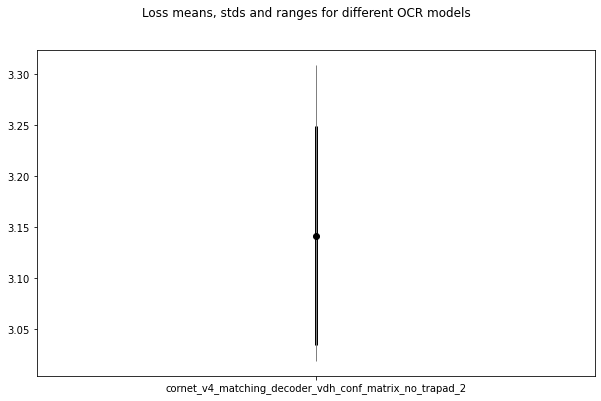

In [12]:
ocr_fn = EMPIRICAL_MODEL_3_FN
learner_args = dict(
    ocr_fn=EMPIRICAL_MODEL_3_FN,
    bs=26*3,
    translate_and_pad=0.,
    param_specs=FONT_MATCHING_PARAM_SPECS, # Add translation parameters
)
fn_suffix = "_exp1_8"
fp = DUMP_FOLDER / f"font__{Path(ocr_fn).stem}{fn_suffix}all"
res = try_load(fp)
if res is None:
    res = fancy_fit_ocr_variations(fn_suffix=fn_suffix,
                                   variations=5,
                                #    iters=2, # New
                                #    epoch_increment=-250, # New
                                #    lr_factor=0.3, # New
                                   min_width=.5, # Let's add this to get rid of possible cul-de-sacs
                                   min_height=.5, # Let's add this to get rid of possible cul-de-sacs
                                   show_sample=False,
                                   init_params=init_params,
                                   max_init_loss=None,
                                   perturb_init_params=.25,
                                   **learner_args,
                                   )
    # show_variation_renders(res, n=4, incl_tfms=True)
stats = plot_loss_stats({ocr_fn: res})

In [13]:
recalculate_losses(res, iters=5, **learner_args)
res.sort(key=lambda o:o["final_loss"])
dump(res, fp)

Recalculating loss for variation 1 of 5...ng_decoder_vdh_conf_matrix_no_trapad_2.pth                                    


/Users/kallejarvenpaa/opt/miniconda3/envs/ai-font-p3.9/lib/python3.9/site-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")
/Users/kallejarvenpaa/Desktop/AI-fontti/aifont/aifont/fontlearner.py:2801: UserWarning: Using default input_shape: (28, 28)
  warn(f"Using default input_shape: {input_shape}")
/Users/kallejarvenpaa/Desktop/AI-fontti/aifont/aifont/fontlearner.py:680: UserWarning: Are you sure you want to define bs when using from_vocab?
  if x in kwargs and kwargs[x] is not None: warn(f"Are you sure you want to define {x} when using from_vocab?")


Recalculating loss for variation 2 of 5...
Recalculating loss for variation 3 of 5...
Recalculating loss for variation 4 of 5...
Recalculating loss for variation 5 of 5...


In [14]:
for r in res:
    learn = None; gc.collect()
    learn = get_learner(**learner_args)
    learn.load_param_dict(r["final_params"])
    learn.fit_one_cycle(150, .3)
    r["finetuned_params_150"] = learn.get_param_dict()
    l = learn.get_current_loss(10)
    r["loss_at_150"] = l
    dump(res, fp)
    if l < r["final_loss"]:
        learn.fit_one_cycle(100, .03)
        r["finetuned_params_250"] = learn.get_param_dict()
        r["loss_at_250"] = learn.get_current_loss(10)
        dump(res, fp)

In [15]:
for i,r in enumerate(res):
    fl = r["final_loss"]
    l2 = r["loss_at_150"]
    l3 = r["loss_at_250"] if "loss_at_250" in r else 9.999
    ld  = fl - l2
    ld2 = l2 - l3
    print(f"Res {i}: loss improvement {ld:.4} • {ld2:.4} | {fl:.4} => {l2:.4} => {l3:.4}")
    ml = min(fl, l2, l3)
    if   ml == fl: bp = r["final_params"]
    elif ml == l2: bp = r["finetuned_params_150"]
    elif ml == l3: bp = r["finetuned_params_250"]
    else: raise Exception("Unknown loss")
    r["best_loss"] = ml
    r["best_params"] = bp
dump(res, fp)

Res 0: loss improvement 0.1984 • 0.01006 | 3.024 => 2.825 => 2.815
Res 1: loss improvement 0.1431 • -0.01025 | 3.059 => 2.916 => 2.926
Res 2: loss improvement 0.25 • -0.004705 | 3.091 => 2.841 => 2.846
Res 3: loss improvement 0.2937 • -0.005725 | 3.249 => 2.955 => 2.961
Res 4: loss improvement 0.3394 • -0.01558 | 3.296 => 2.957 => 2.972


In [16]:
res.sort(key=lambda o:o["best_loss"])
dump(res, fp)

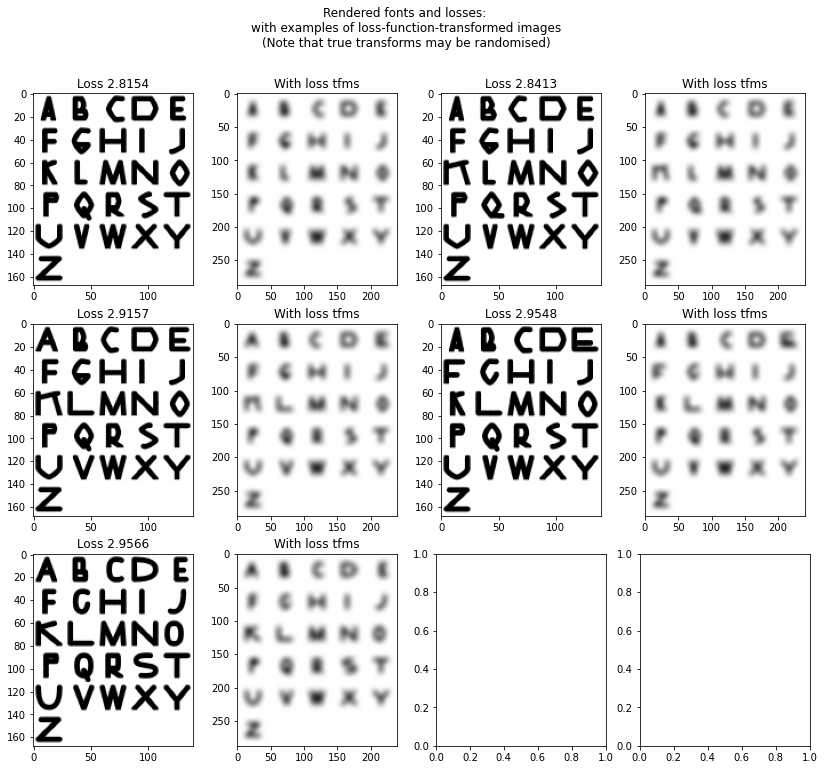

In [17]:
_ = show_variation_renders(
    res, 
    incl_tfms=True, 
    rerender=True,
    learner=get_learner(**learner_args), 
    loss_col="best_loss",
    param_col="best_params"
    )

In [18]:
recalculate_losses(res, incl_loss=False, param_col="best_params", cat_loss_col="best_per_category_loss", 
                   iters=5, **learner_args)
dump(res, fp)

Recalculating loss for variation 1 of 5...ng_decoder_vdh_conf_matrix_no_trapad_2.pth                                    


/Users/kallejarvenpaa/opt/miniconda3/envs/ai-font-p3.9/lib/python3.9/site-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")
/Users/kallejarvenpaa/Desktop/AI-fontti/aifont/aifont/fontlearner.py:2801: UserWarning: Using default input_shape: (28, 28)
  warn(f"Using default input_shape: {input_shape}")
/Users/kallejarvenpaa/Desktop/AI-fontti/aifont/aifont/fontlearner.py:680: UserWarning: Are you sure you want to define bs when using from_vocab?
  if x in kwargs and kwargs[x] is not None: warn(f"Are you sure you want to define {x} when using from_vocab?")


Recalculating loss for variation 2 of 5...
Recalculating loss for variation 3 of 5...
Recalculating loss for variation 4 of 5...
Recalculating loss for variation 5 of 5...


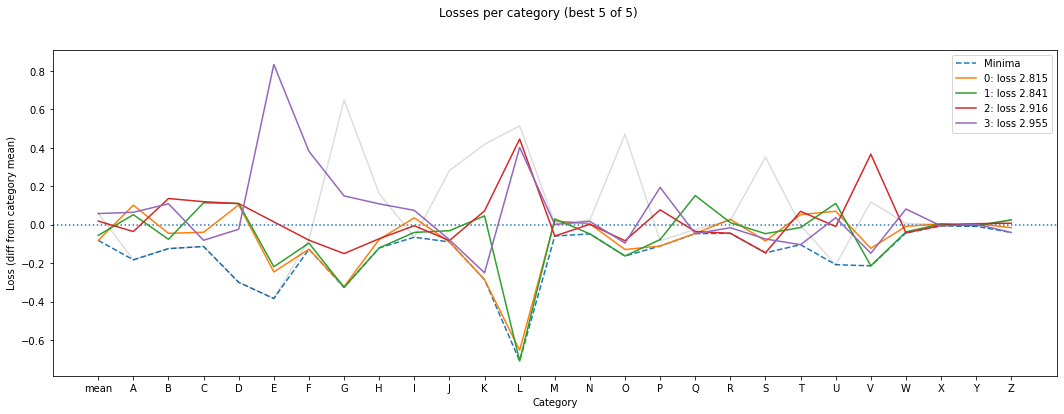

In [19]:
plot_per_category_losses(res, plot_idx=range(4), plot_rest=True, 
                         loss_col="best_loss", cat_loss_col="best_per_category_loss")

In [20]:
cat_loss_col = "best_per_category_loss"
param_col = "best_params"
merged_params = merge_best_parameters(res, param_col=param_col, cat_loss_col=cat_loss_col,
                                      min_improvement=.1)
learn = None; gc.collect()
learn = get_learner(**learner_args)
learn.load_param_dict(merged_params)
l1 = res[0]["best_loss"]
l2 = learn.get_current_loss(10)
print(f"Loss improvement: {l1 - l2:.4} • {l1:.4} => {l2:.4}")


Change 'Width, D' from 3.311 => 3.051
Change 'Crossbar y offset, A' from 3.98 => 0.8515
Change 'Bowl aspect ratio, D' from 3.102 => -2.053
Change 'Bowl aspect ratio, U' from 0.7113 => -1.44
Change 'Upper width n difference, E' from -3.582 => -3.006
Change 'Middle width n difference, E' from 2.767 => 2.854
Change 'Offset x, A' from -0.4398 => -2.163
Change 'Offset x, D' from 0.8832 => 1.294
Change 'Offset x, E' from -0.09097 => 3.044
Change 'Offset x, I' from -3.914 => -3.922
Change 'Offset x, T' from -0.08952 => 0.7792
Change 'Offset x, U' from -0.6834 => -0.6278


/Users/kallejarvenpaa/opt/miniconda3/envs/ai-font-p3.9/lib/python3.9/site-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")
/Users/kallejarvenpaa/Desktop/AI-fontti/aifont/aifont/fontlearner.py:2801: UserWarning: Using default input_shape: (28, 28)
  warn(f"Using default input_shape: {input_shape}")
/Users/kallejarvenpaa/Desktop/AI-fontti/aifont/aifont/fontlearner.py:680: UserWarning: Are you sure you want to define bs when using from_vocab?
  if x in kwargs and kwargs[x] is not None: warn(f"Are you sure you want to define {x} when using from_vocab?")


Loss improvement: -0.2194 • 2.815 => 3.035


In [21]:
best_params = learn.get_param_dict()

In [22]:
learn.fit_one_cycle(100, .02)
clear()
print(l2, learn.get_current_loss(10))

3.0347958326339723 2.825047254562378


NB! "best_params" is actaully worse than the best variation!

In [23]:
best_params_2 = learn.get_param_dict()
# dump(best_params, XXX)

## TODO: Save best params from above

## Interlude: Search for a Working LR Schedule

Perform a search over different lr schedules with just one fitting session.

In [63]:
if False:
    # epochs, lr_max, pct_start
    fit_opts = [
        [300, 1., .25],
        [300, 1., .1],
        [300, .5, .25],
        [300, .5, .1],
        [300, .1, .25],
        [300, .1, .1],
    ]
    fit_res = []
    fn = "fit_options_results.pkl"
    for o in fit_opts:
        print(f"Starting iter {fit_opts.index(o) + 1}/{len(fit_opts)}")
        learn = None; gc.collect()
        learn = get_learner(ocr_fn=EMPIRICAL_MODEL_2_FN, bs=26*3)
        learn.load_param_dict(test_params)
        learn.fit_one_cycle(n_epoch=o[0], lr_max=o[1], pct_start=o[2])
        fit_res.append(dict(
            opts=o,
            lrs=list(learn.recorder.lrs),
            losses=list(learn.recorder.losses),
            img=learn.render_letters(),
            final_params=learn.get_param_dict(),
            final_loss=learn.get_current_loss(10),
        ))
        dump(fit_res, DUMP_FOLDER/fn)
        clear()

Starting iter 6/6


It seems the first options were the best. We can add a few epochs to that just in case. Thus, we'll change the fancy_fit_ocr options to:

    iters = 1,
    epochs = 400,
    lr = 1.,

In [64]:
for o in fit_res:
    print(o["opts"], o["final_loss"])

[300, 1.0, 0.25] 2.6091792821884154
[300, 1.0, 0.1] 2.6111037969589233
[300, 0.5, 0.25] 2.6292974948883057
[300, 0.5, 0.1] 2.651179575920105
[300, 0.1, 0.25] 2.75216326713562
[300, 0.1, 0.1] 2.7250232696533203


## Comparing the results to Arial

Finally, let's compare the losses for Arial to those of our generated model.

### 1. With `translate_and_pad`

First, we need to create a DataFrame with the rendered letters.

/Users/kallejarvenpaa/opt/miniconda3/envs/ai-font-p3.9/lib/python3.9/site-packages/fastai/learner.py:55: UserWarning: Could not load the optimizer state.
  if with_opt: warn("Could not load the optimizer state.")
/Users/kallejarvenpaa/Desktop/AI-fontti/aifont/aifont/fontlearner.py:2797: UserWarning: Using default input_shape: (28, 28)
  warn(f"Using default input_shape: {input_shape}")


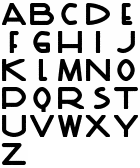

In [74]:
learn = None; gc.collect()
params = load(BEST_PARAMS_3_PATH)
learn = get_learner(ocr_fn=OCR_FNS[0])
learn.load_param_dict(params)
learn.render_letters()

In [75]:
font_df = learn.render_letters_as_df()
font_df.head()

Letter_idx  0_0  0_1  0_2  0_3  0_4  0_5  0_6  0_7  0_8  ...  27_18  27_19  \
0           0    0    0    0    0    0    0    0    0    0  ...      0      0   
1           1    0    0    0    0    0    0    0    0    0  ...      0      0   
2           2    0    0    0    0    0    0    0    0    0  ...      0      0   
3           3    0    0    0    0    0    0    0    0    0  ...      0      0   
4           4    0    0    0    0    0    0    0    0    0  ...      0      0   

   27_20  27_21  27_22  27_23  27_24  27_25  27_26  27_27  
0      0      0      0      0      0      0      0      0  
1      0      0      0      0      0      0      0      0  
2      0      0      0      0      0      0      0      0  
3      0      0      0      0      0      0      0      0  
4      0      0      0      0      0      0      0      0  

[5 rows x 785 columns]

We'll also tweak the size of Arial to match that of our font to maximise the size without clipping any shapes. Let's perform a little search for that.

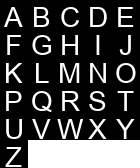

In [76]:
arial_df = get_font_df(font_size=.95)
df_to_image_grid(arial_df)

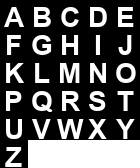

In [91]:
arial_bold_df = get_font_df([SYS_FONT_PATH/"Arial Bold.ttf"], font_size=.95)
df_to_image_grid(arial_bold_df)

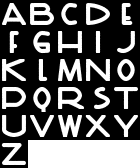

In [77]:
df_to_image_grid(font_df)

/Users/kallejarvenpaa/opt/miniconda3/envs/ai-font-p3.9/lib/python3.9/site-packages/fastai/learner.py:55: UserWarning: Could not load the optimizer state.
  if with_opt: warn("Could not load the optimizer state.")
/Users/kallejarvenpaa/Desktop/AI-fontti/aifont/aifont/fontlearner.py:2797: UserWarning: Using default input_shape: (28, 28)
  warn(f"Using default input_shape: {input_shape}")


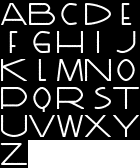

In [93]:
# Create a df for a font with stroke width matched with Arial
learn = None; gc.collect()
params = load(BEST_PARAMS_2_PATH)
learn = get_learner(ocr_fn=OCR_FNS[0])
learn.load_param_dict(params)
learn.set_param("Stroke width", -1.0305887460708618)
font_2_df = learn.render_letters_as_df()
df_to_image_grid(font_2_df)

Font size .95 seems to be fine. With 1. we get clipping.

#### Perform accuracy comparison

We edit the empirical fine tuning tfms a bit so to avoid the effects of the OCR model's possible overfitting.

In [83]:
EMPIRICAL_FINETUNING_TFMS = dict(
    use_affine_tfms=False,
    use_xtra_tfms=True, 
    tfms_p=1.,
    blur_size=17,
    blur_sigma=(4.41 - .2, 4.41 + .2), # Add random variation
    noise_f=None, # .1, # Let's see if this cures overfitting
    size=48,
    normalize=True,
    translate_and_pad=.2
)

#### Accuracies for the fonts with different configurations

| Version                     | Arial  | Arial Bold | AI Font | AI Font 2 |
| ---                         | ---    | ---        | ---     | ---       |
| A. defaults                 | 0.4614 |     0.4576 |  0.4799 |    0.3977 |
| B. A + translate_and_pad=.0 | 0.4938 |     0.4933 |  0.5335 |    0.403  |
| C. B + blur_sigma=5.41±.2   | 0.3766 |     0.3825 |  0.4871 |    0.3469 |

* AI Font 2 is our optimised font with its stroke width matched with Arial.

| Arial  | Arial Bold | AI Font | AI Font 2 |
| 0.3766 |     0.3825 |  0.4871 |    0.3469 |


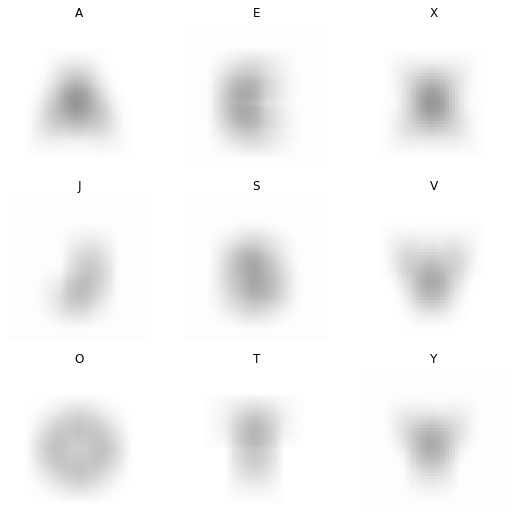

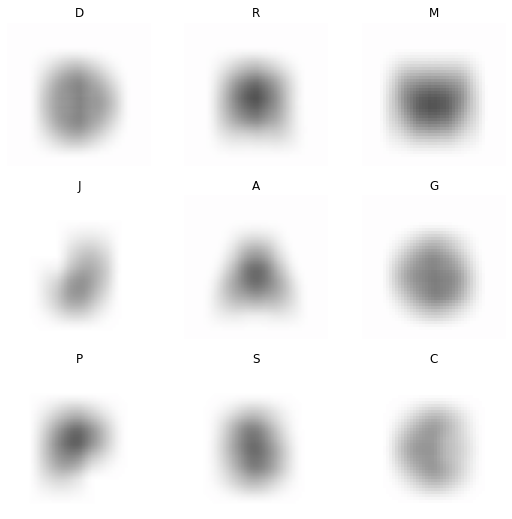

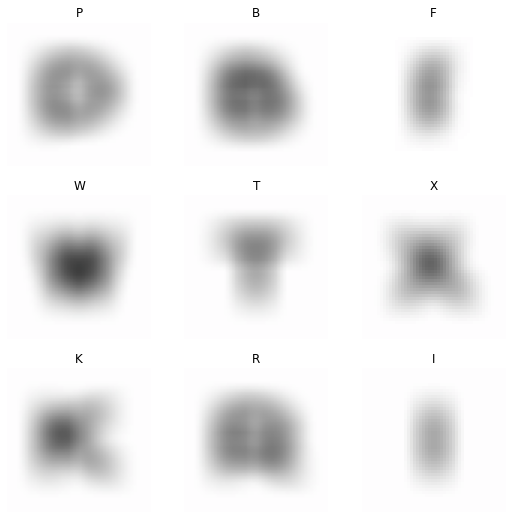

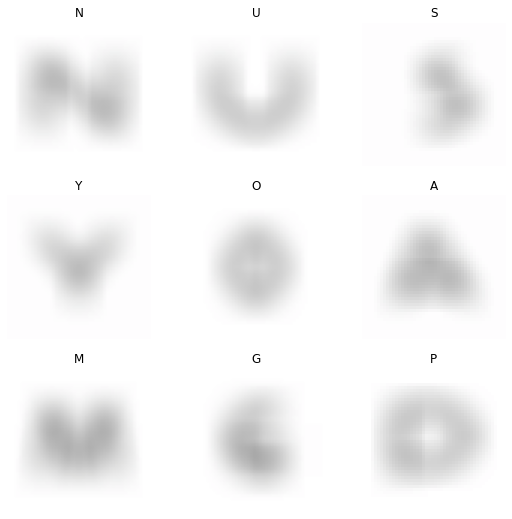

In [96]:
ocr_model = load_ocr_model(file=EMPIRICAL_MODEL_2_FN, arch=cornet_for_ocr, n_out=26)
tfms = {
    **EMPIRICAL_FINETUNING_TFMS,
    "translate_and_pad": 0., # Tfms B
    # "noise_f": None, # .1
    # "blur_size": 13, # Original blur_size: 17
    "blur_sigma": (5.41 - .2, 5.41 + .2), # Tfms C
    }
acc_args = dict(iters=500, 
                splitter=cornet_splitter,
                **tfms)
acc_arial   = get_model_accuracy_metrics(ocr_model, df=arial_df, **acc_args)
acc_arial_b = get_model_accuracy_metrics(ocr_model, df=arial_bold_df, **acc_args)
acc_font    = get_model_accuracy_metrics(ocr_model, df=font_df, **acc_args)
acc_font_2  = get_model_accuracy_metrics(ocr_model, df=font_2_df, **acc_args)
clear()
print(f"| Arial  | Arial Bold | AI Font | AI Font 2 |")
print(f"| {acc_arial[1]:0.4} |     {acc_arial_b[1]:0.4} |  {acc_font[1]:0.4} |    {acc_font_2[1]:0.4} |")

### 2. Reperform Accuracy Comparison With a Model Trained Completely Without `translate_and_pad`

Relevant variables.

In [11]:
ocr_fn = EMPIRICAL_MODEL_3_FN
param_path = BEST_PARAMS_3_PATH
tfms = dict(
    use_affine_tfms=False,
    use_xtra_tfms=True, 
    tfms_p=1.,
    blur_size=17,
    blur_sigma=(4.41 - .2, 4.41 + .2), # Add random variation
    noise_f=None,
    size=48,
    normalize=True,
    translate_and_pad=0.
)

Create the necessary font `DataFrames`.

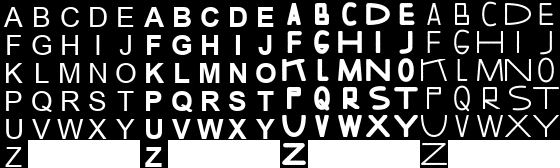

In [15]:
learn = None; gc.collect()
learn = get_learner(ocr_fn=ocr_fn)
learn.load_param_dict(load(param_path))
font_df = learn.render_letters_as_df()
# Match stroke width with Arial
learn.set_param("Stroke width", -1.0305887460708618)
font_2_df = learn.render_letters_as_df()
arial_df = get_font_df(font_size=.95)
arial_bold_df = get_font_df([SYS_FONT_PATH/"Arial Bold.ttf"], font_size=.95)
dfs = [arial_df, arial_bold_df, font_df, font_2_df]
clear()
image_grid([df_to_image_grid(o) for o in dfs], cols=4)

Perform a few comparisons.

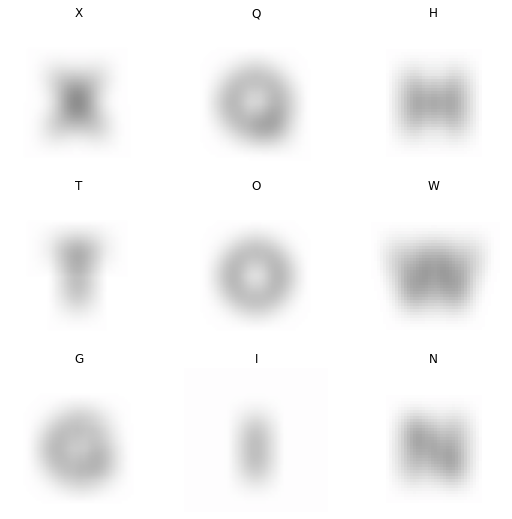

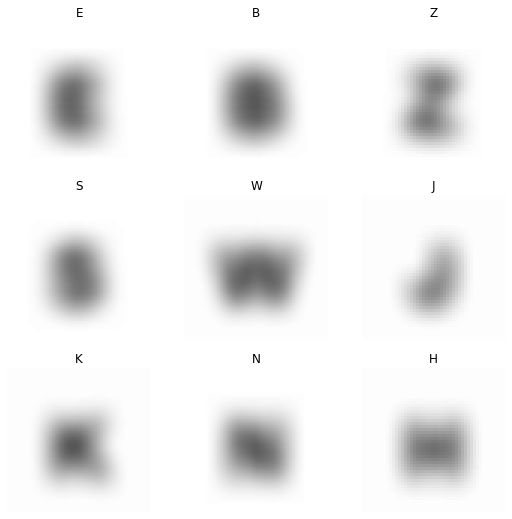

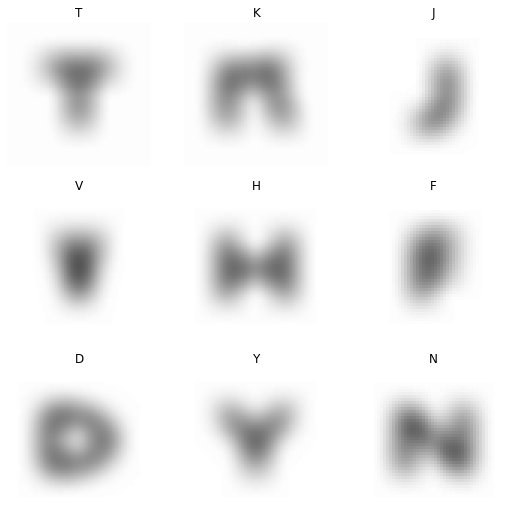

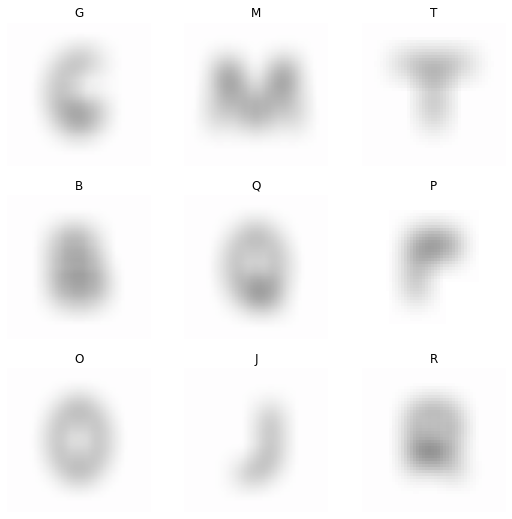

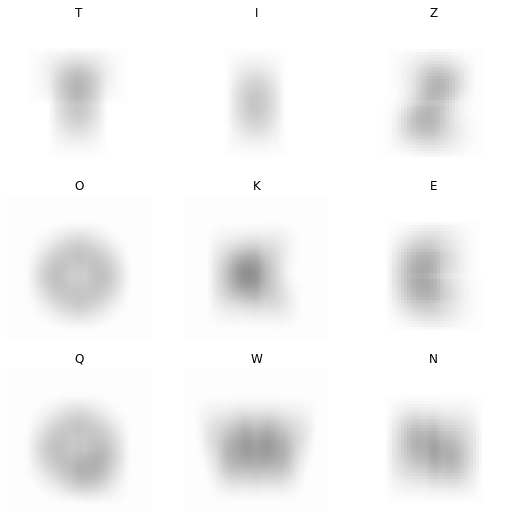

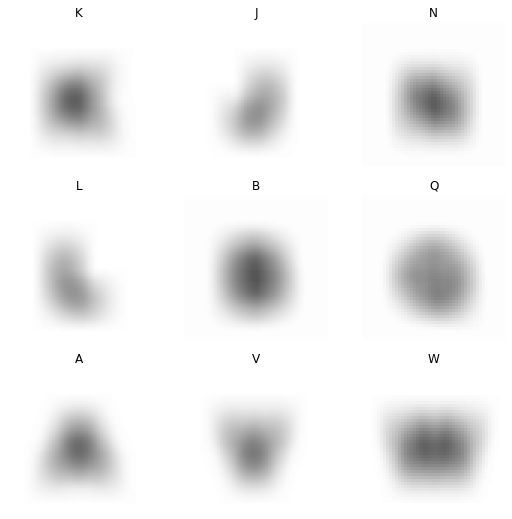

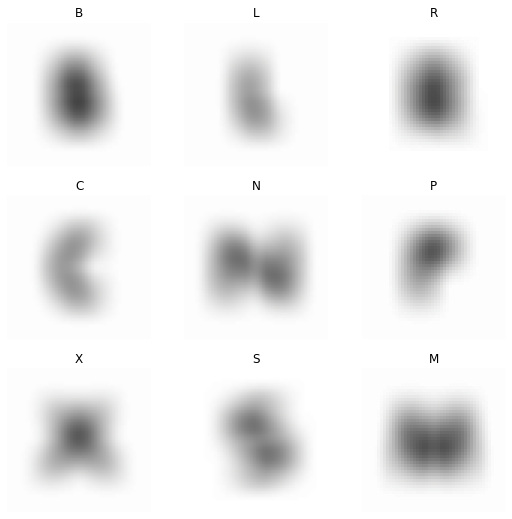

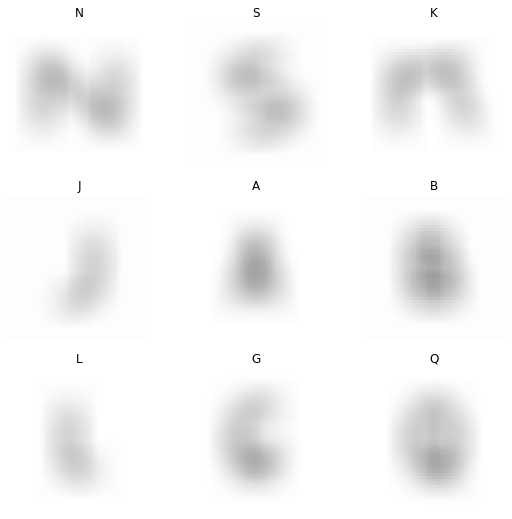

In [16]:
ocr_model = load_ocr_model(file=ocr_fn, arch=cornet_for_ocr, n_out=26)
accs = OrderedDict()
acc_args = dict(iters=500, 
                splitter=cornet_splitter,
                **tfms)
accs["Default "] = [get_model_accuracy_metrics(ocr_model, df=df, **acc_args) for df in dfs]
clear()
acc_args["blur_sigma"] = [o+1 for o in acc_args["blur_sigma"]]
accs["Sigma +1"] = [get_model_accuracy_metrics(ocr_model, df=df, **acc_args) for df in dfs]
clear()

In [8]:
accs_fp = DUMP_FOLDER/"Accracies_no_trapad.pkl"
# dump(accs, accs_fp)
accs = load(accs_fp)

In [10]:
print(f"| Condition  | Arial      | Arial Bold | AI Font    | AI Font 2  |")
print(f"| ---------- " * 5 + "|")
for k,v in accs.items():
    print("".join([f"| {k:<10} "] + [f"| {o[1]:>10.4} " for o in v]) + "|")

| Condition  | Arial      | Arial Bold | AI Font    | AI Font 2  |
| ---------- | ---------- | ---------- | ---------- | ---------- |
| Default    |     0.5105 |     0.4857 |     0.5555 |      0.416 |
| Sigma +1   |      0.472 |     0.4386 |     0.4804 |     0.3762 |


### Accuracies for Fonts Without `translate_and_pad`

| Condition  | Arial      | Arial Bold | AI Font    | AI Font 2  | AI Font 3  | AI Font 4  | AI Arial   |
| ---------- | ---------- | ---------- | ---------- | ---------- | ---------- | ---------- | ---------- |
| Default    |     0.5105 |     0.4857 |     0.5555 |     0.416  |     0.4103 |     0.426  |     0.5023 |
| Sigma +1   |     0.472  |     0.4386 |     0.4804 |     0.3762 |     0.3547 |     0.3884 |     0.4689 |

NB. See addenda below for AI Font 3 and 4.

The second condition has a higher value of the sigma parameter for Gaussian blur than the one used in both training the OCR model and optimising the font.

For both conditions, the optimised font has a higher accuracy, although the difference is smaller in the second case. This hints to the font being optimised to a specific value for sigma. However, the poor accuracy may also be the result of the OCR model being trained with that sigma. **It might be worthwhile to measure these accuracies with an OCR model trained with the higher sigma.**

To gauge whether the optimised font's accuracy is merely due to its bolder strokes, which may confer an advantage in blurred conditions, the comparison includes both Arial Bold and a versions of the optimised font (AI Font 2 and 3) whose stroke width is matched to that of Arial.

Interestingly, Arial Bold's accuracy is lower than the regular font's, which may be a result of it not being included in the blurred fine-tuning phase. On the other hand, due to its exclusion along with other bold fonts (in truth, nor was Arial Regular part of the fine-tuning dataset but it included very similar fonts) it may offer a fairer comparison to the optimised font, which obviously was out of distribution.

The poor performance of the thinner-stroke version of the optimised font is surprising in its severity but perhaps understandable due to it not being optimised to take into account the thinner stroke width. AI Font 3 is a version which was fine-tuned after setting the thinner stroke width but did not improve by doing that. It, in fact, deteriorated a bit, although training loss did slightly decreased from 3.7190 to 3.4871. 

A better comparison in terms of fonts of equal stroke width is AI Font 4, which is optimised from scratch with stroke width frozen. Its performace, however, is only slightly better, which is quite confounding. For yet another comparison, let's optimise a font starting from parameters that match Arial and see where that leads.

### Addendum to Experiment 1 Rerun 6b: Fine-Tune the Thinner-Stroke Font

To offer a fairer comparison to Arial in terms of accuracy measurements, let's fine-tune the optimised font whose stroke width was rather brutally altered with the stroke width parameter frozen.

In [16]:
learn = None; gc.collect()
learner_args = dict(
    ocr_fn=EMPIRICAL_MODEL_3_FN,
    bs=26*3,
    translate_and_pad=0.
)
learn = get_learner(**learner_args)
learn.load_param_dict(load(param_path))
# Match stroke width with Arial
learn.set_param("Stroke width", -1.0305887460708618)
learn.freeze_params(["Stroke width"])
clear()
learn.get_current_loss(10)

3.719015383720398

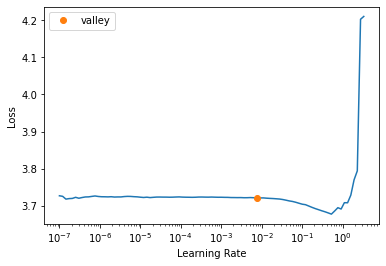

In [18]:
lrs = learn.lr_find()

In [19]:
learn.fit_one_cycle(200, .3)

In [20]:
params_200 = learn.get_param_dict()

In [21]:
learn.fit_one_cycle(200, .15)

In [22]:
params_400 = learn.get_param_dict()

In [23]:
l_400 = learn.get_current_loss(10)
learn.load_param_dict(params_200)
l_200 = learn.get_current_loss(10)
l_200, l_400

(3.4945312261581423, 3.4870849609375)

In [25]:
dump(params_400, BEST_PARAMS_3_THIN_STROKE_PATH)

|     0.4103 |     0.3547 |


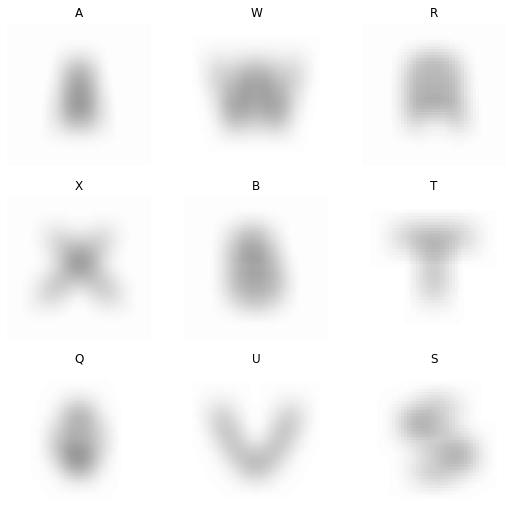

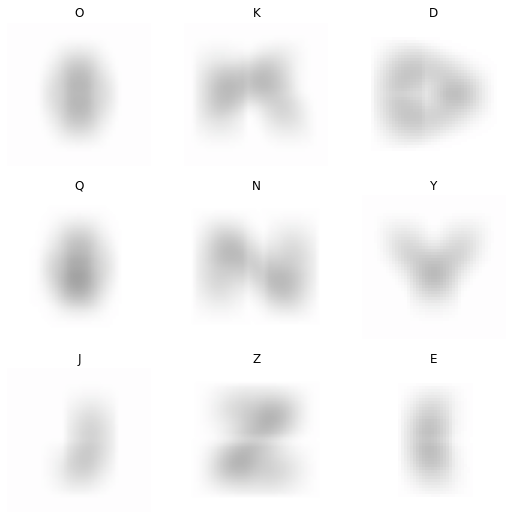

In [27]:
learn.load_param_dict(load(BEST_PARAMS_3_THIN_STROKE_PATH))
font_3_df = learn.render_letters_as_df()
ocr_fn = EMPIRICAL_MODEL_3_FN
ocr_model = load_ocr_model(file=ocr_fn, arch=cornet_for_ocr, n_out=26)
acc_args = dict(iters=500, 
                splitter=cornet_splitter,
                **tfms)
acc_font_3 = get_model_accuracy_metrics(ocr_model, df=font_3_df, **acc_args)
acc_args["blur_sigma"] = [o+1 for o in acc_args["blur_sigma"]]
acc_font_3_sp1 = get_model_accuracy_metrics(ocr_model, df=font_3_df, **acc_args)
# 0.416 | 0.3762
clear()
print("".join([f"| {o[1]:>10.4} " for o in [acc_font_3, acc_font_3_sp1]]) + "|")

Hmmm… This didn't result in any improvements:

| Condition  | Arial      | Arial Bold | AI Font    | AI Font 2  | AI Font 3  |
| ---------- | ---------- | ---------- | ---------- | ---------- | ---------- |
| Default    |     0.5105 |     0.4857 |     0.5555 |      0.416 |     0.4103 |
| Sigma +1   |      0.472 |     0.4386 |     0.4804 |     0.3762 |     0.3547 |

A better comparison would be to freeze the stroke width in the beginning and optimise from scratch, which we'll forgo for now.

### Addendum to Experiment 1: Fully Optimised Font With Frozen Thin Stroke

To offer a fairer comparison to Arial in terms of accuracy measurements, we also optimised one font with the stroke width frozen to a value matching that of Arial's.

In [58]:
ocr_fn = EMPIRICAL_MODEL_3_FN
tfms = dict(
    use_affine_tfms=False,
    use_xtra_tfms=True, 
    tfms_p=1.,
    blur_size=17,
    blur_sigma=(4.41 - .2, 4.41 + .2), # Add random variation
    noise_f=None,
    size=48,
    normalize=True,
    translate_and_pad=0.
)

Compare the results from the full optimisation and the mere fine tuning.

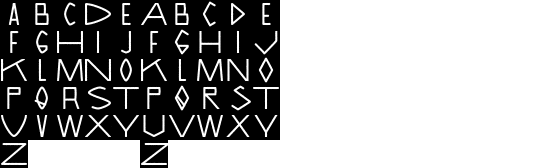

In [59]:
learn = None; gc.collect()
learn = get_learner(ocr_fn=ocr_fn)
learn.load_param_dict(load(BEST_PARAMS_3_THIN_STROKE_PATH))
font_3_df = learn.render_letters_as_df()
learn.load_param_dict(load(BEST_PARAMS_4_THIN_STROKE_PATH))
font_4_df = learn.render_letters_as_df()
dfs = [font_3_df, font_4_df]
clear()
display(image_grid([df_to_image_grid(o) for o in dfs], cols=4))

Get accuracy for AI Font 4.

|      0.426 |     0.3884 |


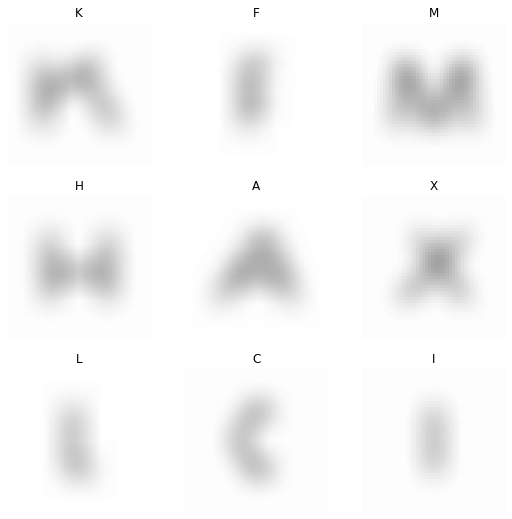

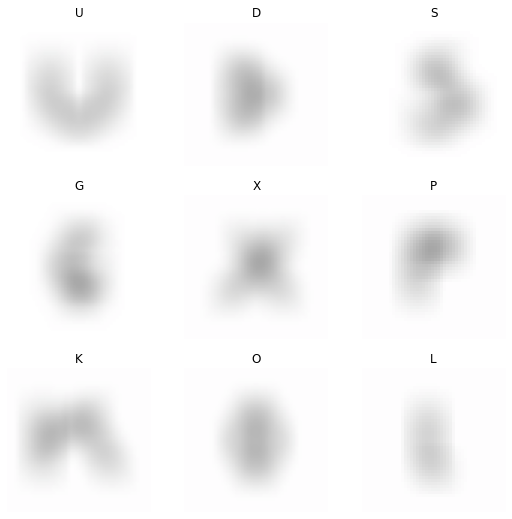

In [60]:
ocr_model = load_ocr_model(file=ocr_fn, arch=cornet_for_ocr, n_out=26)
acc_args = dict(iters=500, 
                splitter=cornet_splitter,
                **tfms)
acc_font_4 = get_model_accuracy_metrics(ocr_model, df=font_4_df, **acc_args)
acc_args["blur_sigma"] = [o+1 for o in acc_args["blur_sigma"]]
acc_font_4_sp1 = get_model_accuracy_metrics(ocr_model, df=font_4_df, **acc_args)
clear()
print("".join([f"| {o[1]:>10.4} " for o in [acc_font_4, acc_font_4_sp1]]) + "|")

### Addendum: Use Params that Match for Arial

Let's see if there's any difference between the accuracy for real Arial and created using matching.

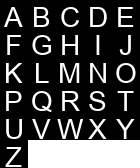

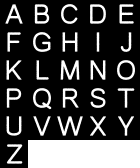

In [73]:
arial_params = load(ARIAL_SIZE_95_PARAMS_PATH)
arial_df = get_font_df(font_size=.95)
arial_fake_df = get_font_model_df(arial_params)
clear()
display(df_to_image_grid(arial_df))
display(df_to_image_grid(arial_fake_df))

|     0.5023 |     0.4689 |


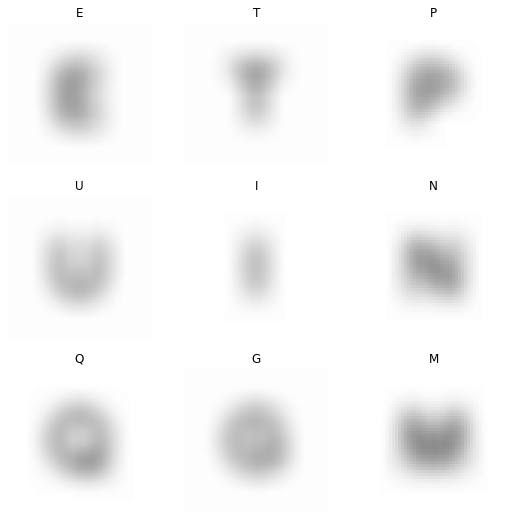

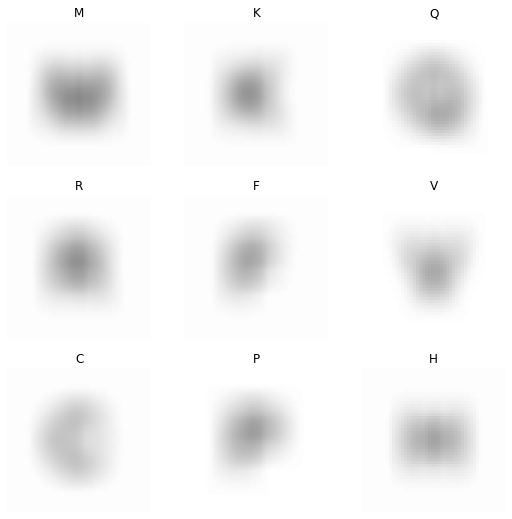

In [74]:
acc_5, acc_5_sp1 = get_accuracy_for_params(load(ARIAL_SIZE_95_PARAMS_PATH))


### Deprecated: Results From the Fully-Unfrozen Model

Very curiously, our optimised font does seems to trail Arial's accuracy by .01. This is true even for these variations:

* Using the params that matched Arial in Experiment 1 (with Height matched to the optimised one)
* Matching height with that of Arial
* Matching stroke weight with that of Arial (accuracy drops from ~.460 to ~.414)
* Using a normal curvature (almost no difference)

However, when we add even just a bit of noise to move out of training distribution, our font clearly outperforms Arial (.254 vs. .111 with f=.1 Noise). Let's still check if that is only due to the stroke width and match that with Arial. Hmmm, the weight, which leads to reduction in contrast seems to be the decisive issue, as the lighter optimised fonts trails Arial by .01.

Let's make another test using the OCR model before it was finetuned with the heavy augmentations.

* With noise, the results are interesting with accuracies of 0.47049659490585327, 0.6864513158798218 and 0.5998385548591614 for Arial, optimised font and weight-matched optimised font, respectively
* Without noise, the outperformance of the optimised models is almost equal at 0.5590537190437317, 0.7301685810089111 and 0.6935827136039734

For further exploration, let's try matching with the empirical model, no noise but with a smaller blur kernel.

* With blur_size, the optimised font slightly outperforms Arial at 0.4472791850566864 0.4554043710231781 0.39969462156295776 – notably the accuracy is worse than for the larger blur, but that may result from too high sigma for that size. Let's try with a lower sigma as well.
* With blur_size 13 and sigma (3 - .75, 3 + .75), Arial is again victorious (although with much lower accuracy than with high blur!) at 0.32112109661102295, 0.28092077374458313 and 0.2984592020511627. This is understandable, as the blur is not strong enough to make the letters illegible.

> These findings raise the possibility that maybe we should finetune another model, where the confusion-matrix matching is done with changes to the decoder (or IT layer) only.

0.32112109661102295 0.28092077374458313 0.2984592020511627


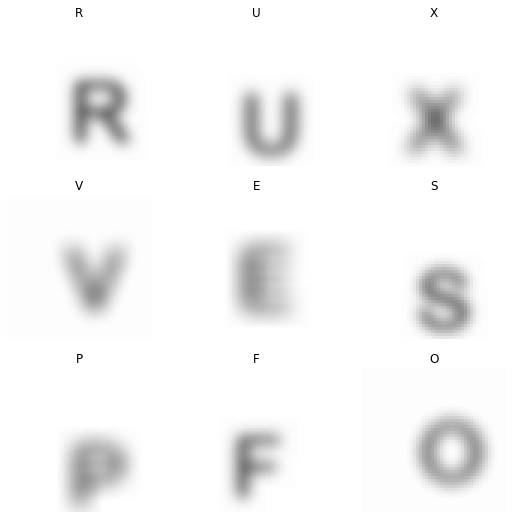

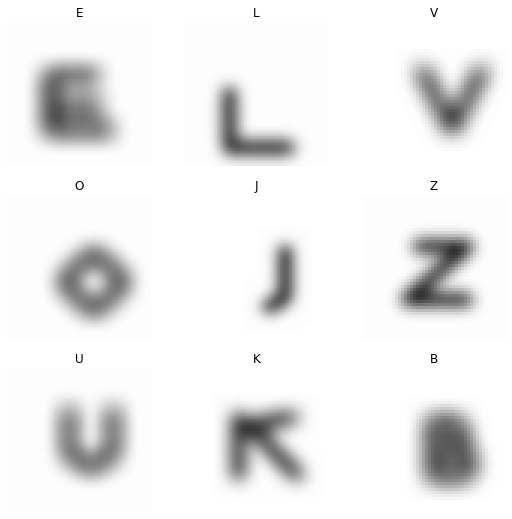

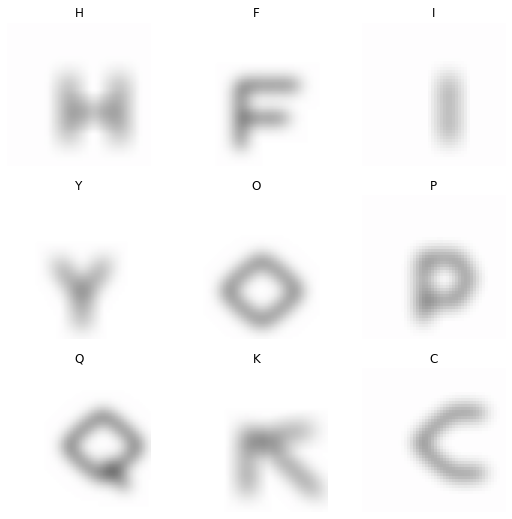

In [51]:
ocr_model = load_ocr_model(file=EMPIRICAL_MODEL_FN, arch=cornet_for_ocr, n_out=26)
# ocr_model = load_ocr_model(file="cornet_fullds_blur_v4.pth", arch=cornet_for_ocr, n_out=26)
tfms = {
    **EMPIRICAL_FINETUNING_TFMS,
    "noise_f": None, # .1
    "blur_size": 13, # Original blur_size: 17
    "blur_sigma": (3 - .75, 3 + .75), # (4.41 - 1., 4.41 + 1.)
    } 
acc_args = dict(iters=500, 
                splitter=cornet_splitter,
                **tfms)
acc_arial  = get_model_accuracy_metrics(ocr_model, df=arial_df, **acc_args)
acc_font   = get_model_accuracy_metrics(ocr_model, df=font_df, **acc_args)
acc_font_2 = get_model_accuracy_metrics(ocr_model, df=font_2_df, **acc_args)

clear()

print(acc_arial[1], acc_font[1], acc_font_2[1])

In [31]:
np_arial = np.array(list(acc_arial[2].values()))
np_font  = np.array(list(acc_font[2].values()))
acc_diff = (np_font - np_arial) / np_arial
acc_diff = {list(acc_arial[2].keys())[i]: f"{acc_diff[i]: .2%}" for i in range(len(acc_diff))}
acc_diff

{'A': '-0.08%',
 'B': '-5.11%',
 'C': ' 40.00%',
 'D': '-9.75%',
 'E': ' 9.34%',
 'F': '-22.48%',
 'G': ' 96.70%',
 'H': '-13.21%',
 'I': '-2.55%',
 'J': '-1.45%',
 'K': '-23.92%',
 'L': ' 1.59%',
 'M': ' 15.51%',
 'N': ' 2.69%',
 'O': '-0.39%',
 'P': '-39.70%',
 'Q': '-28.75%',
 'R': '-17.40%',
 'S': '-29.72%',
 'T': '-8.94%',
 'U': '-4.55%',
 'V': '-2.50%',
 'W': ' 20.54%',
 'X': '-24.15%',
 'Y': '-3.62%',
 'Z': '-9.10%'}

Params in b but not in a: Slant; Offset y; Offset x, A; Offset x, B; Offset x, C; Offset x, D; Offset x, E; Offset x, F; Offset x, G; Offset x, H; Offset x, I; Offset x, J; Offset x, K; Offset x, L; Offset x, M; Offset x, N; Offset x, O; Offset x, P; Offset x, Q; Offset x, R; Offset x, S; Offset x, T; Offset x, U; Offset x, V; Offset x, W; Offset x, X; Offset x, Y; Offset x, Z • Params in a but not in b: 


/Users/kallejarvenpaa/opt/miniconda3/envs/ai-font-p3.9/lib/python3.9/site-packages/fastai/learner.py:55: UserWarning: Could not load the optimizer state.
  if with_opt: warn("Could not load the optimizer state.")
/Users/kallejarvenpaa/Desktop/AI-fontti/aifont/aifont/fontlearner.py:2740: UserWarning: Using default input_shape: (28, 28)
  warn(f"Using default input_shape: {input_shape}")


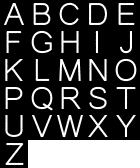

In [42]:
match_arial_params = load("results/test_10_augmented/match_font_Arial_final")
match_arial_params["Height"] = params["Height"]
learn = None; gc.collect()
learn = get_learner(ocr_fn=OCR_FNS[0])
learn.load_param_dict(match_arial_params)
match_arial_df = learn.render_letters_as_df()
df_to_image_grid(match_arial_df)

In [43]:
match_arial_params["Stroke width"]

-1.0305887460708618

In [55]:
acc_match_arial = get_model_accuracy_metrics(ocr_model, df=match_arial_df, **acc_args)
clear()
print(acc_match_arial[1])

0.44478678703308105


## Create Visualisations

### Render SVG Letters: B for Model Anatomy

Load results and see, which version is good for the visualisation.

/Users/kallejarvenpaa/opt/miniconda3/envs/ai-font-p3.9/lib/python3.9/site-packages/fastai/learner.py:55: UserWarning: Could not load the optimizer state.
  if with_opt: warn("Could not load the optimizer state.")
/Users/kallejarvenpaa/Desktop/AI-fontti/aifont/aifont/fontlearner.py:2797: UserWarning: Using default input_shape: (28, 28)
  warn(f"Using default input_shape: {input_shape}")
/Users/kallejarvenpaa/Desktop/AI-fontti/aifont/aifont/fontlearner.py:680: UserWarning: Are you sure you want to define bs when using from_vocab?
  if x in kwargs and kwargs[x] is not None: warn(f"Are you sure you want to define {x} when using from_vocab?")


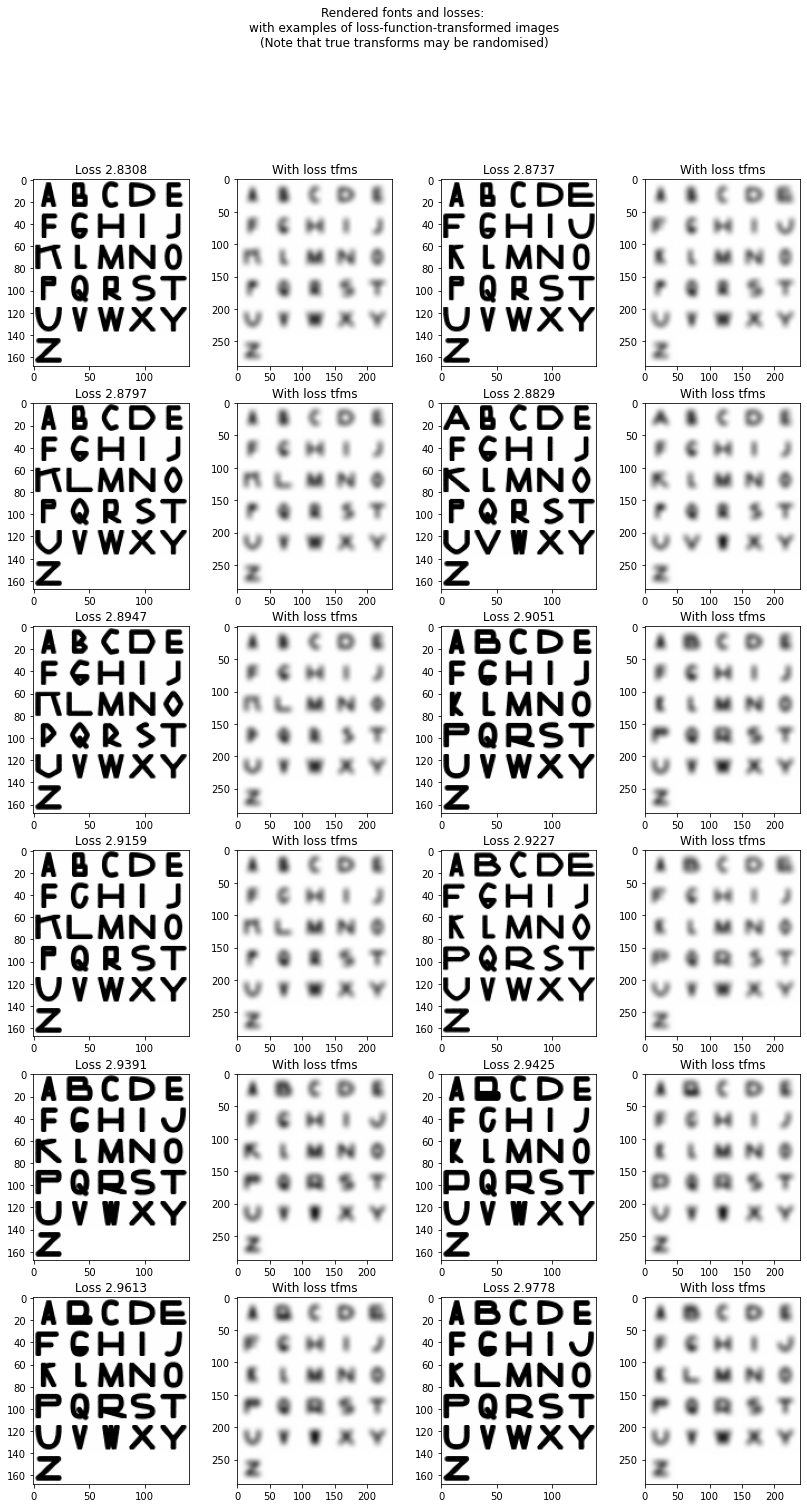

In [32]:
ocr_fn = EMPIRICAL_MODEL_3_FN
learner_args = dict(
    ocr_fn=EMPIRICAL_MODEL_3_FN,
    bs=26*3,
    translate_and_pad=0.
)
learn = get_learner(**learner_args)
param_col="best_params"
fn_suffix = "_exp1_6b" # _6a was with translate_and_pad at its default value
fp = DUMP_FOLDER / f"font__{Path(ocr_fn).stem}{fn_suffix}all"
res = try_load(fp)
_ = show_variation_renders(
    res, 
    incl_tfms=True, 
    rerender=True,
    learner=learn, 
    loss_col="best_loss",
    param_col=param_col
    )

We'll pick variation 7.

In [37]:
idx = 7
fp = DUMP_FOLDER/"Sample_letter_for_anatomy"
learn.load_param_dict(res[idx][param_col])
learn.save_svg(fp, "AB")
fp

Path('results/test_nb12_augmented/Sample_letter_for_anatomy')

In [38]:
learn.model.get_param_value("Midline")

tensor(0.5405, grad_fn=<AddBackward0>)

## Export

In [ ]:
#hide
from nbdev.export import notebook2script; notebook2script()

Converted 00_core.ipynb.
Converted 01_fontsampler.ipynb.
Converted 02_ocrlearner.ipynb.
Converted 03_fontlearner.ipynb.
Converted index.ipynb.
